In [1]:
import xml.etree.ElementTree
import pandas as pd
import os, sys
import pickle

MNET_PATH = '/Volumes/Transcend2/git/molnet/code'
sys.path.append(MNET_PATH)

In [2]:
WIN = 'D:/'
MAC = '/Volumes/Transcend2/'

osp = MAC

In [3]:
sys.path.append('..')
import alignment

## Create metabolites dictionary

Parse metabolites list downloaded from HMDB in xml format

In [4]:
path_to_hmdbfile = osp+ 'Metabolomics_datasets/serum_metabolites.xml'
et = xml.etree.ElementTree.parse(path_to_hmdbfile)
root = et.getroot()


KeyboardInterrupt: 

In [4]:
metabolites = {}
stringtag = '{http://www.hmdb.ca}'
for metabolite in root.findall(stringtag+'metabolite'):
    accid = metabolite.find(stringtag+'accession').text
    name = metabolite.find(stringtag+'name').text
    mass = metabolite.find(stringtag+'average_molecular_weight').text
    chemform = metabolite.find(stringtag+'chemical_formula').text
    
    metabolites[accid] = (mass, chemform, name)  
    
with open(os.path.join(osp,'Metabolomics_datasets/metabolites.dict'), 'wb') as handle:
    pickle.dump(metabolites, handle)  

In [4]:
with open(os.path.join(osp,'Metabolomics_datasets/metabolites.dict'), 'rb') as file:
    metabolites = pickle.load(file)

## Load annotated data

In [5]:
annotated_data = pd.read_csv(osp+'pymz/mzmine/221119/annotated_data.csv', sep = ',', index_col = 0)

## Filter out data with no spectra

In [21]:
with open(os.path.join(osp,'pymz/mzmine/aligner_gp.txt'), 'rb') as file:
    aligner_gp = pickle.load(file)   

In [22]:
peaksets = []
annotated_data['spectra'] = ['nan']*len(annotated_data)
for peakid in annotated_data['custom_id']:
    new_peakid = peakid - 1
    np = aligner_gp.peaksets[new_peakid].n_peaks
    spectra = {}
    if np > 1:
        for i in range(np-1):
            source = aligner_gp.peaksets[new_peakid].peaks[i+1].source_file
            msms = aligner_gp.peaksets[new_peakid].peaks[i+1].ms2_spectrum
            spectra[source] = msms
        annotated_data.at[peakid,'spectra'] = spectra


## Add possible adducts for each peak and their respective HMDB accession id

In [23]:
def compute_adducts(mz, positive = True):
    
    PROTON = 1.00727646677
    if positive:
        addList = [(mz - PROTON, 'M+H[1+]', ''),
             ((mz - PROTON)*2, 'M+2H[2+]', ''),
             ((mz - PROTON)*3, 'M+3H[3+]', ''),
             (mz - 1.0034 - PROTON, 'M(C13)+H[1+]', 'C'),
             ((mz - 0.5017 - PROTON)*2, 'M(C13)+2H[2+]', 'C'),
             ((mz - 0.3344 - PROTON)*3, 'M(C13)+3H[3+]', 'C'),
             (mz -1.9958 - PROTON, 'M(S34)+H[1+]', 'S'),
             (mz -1.9972 - PROTON, 'M(Cl37)+H[1+]', 'Cl'),
             (mz - 21.9820 - PROTON, 'M+Na[1+]', ''), 
             ((mz - 10.991 - PROTON)*2, 'M+H+Na[2+]', ''),
             (mz - 37.9555 - PROTON, 'M+K[1+]', ''), 
             (mz - 18.0106 - PROTON, 'M+H2O+H[1+]', ''), 
             (mz + 18.0106 - PROTON, 'M-H2O+H[1+]', 'H2O'), 
             (mz + 36.0212 - PROTON, 'M-H4O2+H[1+]', 'H4O2'),
             (mz + 17.0265 - PROTON, 'M-NH3+H[1+]', 'NH3'),
             (mz + 27.9950 - PROTON, 'M-CO+H[1+]', 'CO'),
             (mz + 43.9898 - PROTON, 'M-CO2+H[1+]', 'CO2'),
             (mz + 46.0054 - PROTON, 'M-HCOOH+H[1+]', 'H2CO2'),
             (mz - 67.9874 - PROTON, 'M+HCOONa[1+]', ''),
             (mz + 67.9874 - PROTON, 'M-HCOONa+H[1+]', 'HCO2Na'),
             (mz - 57.9586 - PROTON, 'M+NaCl[1+]', ''), 
             (mz + 72.0211 - PROTON, 'M-C3H4O2+H[1+]', 'C3H4O2'),
             (mz - 83.9613 - PROTON, 'M+HCOOK[1+]', ''),
             (mz + 83.9613 - PROTON, 'M-HCOOK+H[1+]', 'HCO2K'),
             ] 

    return addList

In [24]:
def annotate_adduct(adducts, metabolites, tolerance = 0.01):
    ids = []
    names = []
    for adduct in adducts:
        mw = adduct[0]
        for key in metabolites:
            if metabolites[key][0] != None:
                if mw > float(metabolites[key][0]) - tolerance and mw < float(metabolites[key][0]) + tolerance:
                    ids.append(key)
                    names.append(metabolites[key][2])
    return ids, names
        

In [25]:
annotated_data['adducts'] = ['nan']*len(annotated_data)
for i,row in annotated_data.iterrows():
    mz = row['row m/z']
    annotated_data.at[i, 'adducts'] = compute_adducts(mz)

In [27]:
annotated_data['hmdbacc']=['nan']*len(annotated_data)
annotated_data['hmdbname']=['nan']*len(annotated_data)
for i,row in annotated_data.iterrows():
    adducts = row['adducts']
    
    
    ids, names = annotate_adduct(adducts, metabolites, 0.2)
    
    annotated_data.at[i, 'hmdbacc'] = ids
    annotated_data.at[i, 'hmdbname'] = names
        

## Get ms2 data from HMDB ms2 xml files

In [28]:
def get_ms2_spec_from_hmdb(file, parent_mz):
    import mnet
    path_to_hmdbfile = file
    et = xml.etree.ElementTree.parse(path_to_hmdbfile)
    element = et.getroot()
    mode = element.find('ionization-mode').text
    if mode == 'positive':
        instrtype = element.find('instrument-type').text
        filename = element.find('database-id').text
        np = element.find('peak-counter').text
        peaks = []
        
        for msms in element.find('ms-ms-peaks'):
            mz = float(msms.find('mass-charge').text)
            intensity = float(msms.find('intensity').text)
            
            peaks.append((mz, intensity))
            
        
        ms2_spectrum = mnet.Spectrum(peaks, filename, None, None, parent_mz, parent_mz, metadata = (instrtype, mode))
        return ms2_spectrum
    

In [29]:
def return_best_match_metabolite(ms2specdata, hmdbacclist):
    import glob
    from scoring_functions import fast_cosine
   
    best_score_metab = 0.0
    best_metab_tuple = (0,0,0)
    for acc in hmdbacclist:
        
        files = glob.glob(os.path.join(osp+ 'Metabolomics_datasets/hmdb_experimental_msms_spectra/', acc+'*'))
        if len(files)>0:
            best_score_acc = 0.0
            best_ms2_acc = 'nan'
            for file in files:
                ms2spec = get_ms2_spec_from_hmdb(file, float(metabolites[acc][0]))
                if ms2spec != None: #msms is positive
                    score, used_matches = fast_cosine(ms2spec, ms2specdata, 0.2, 2)
                    
                    if score > best_score_acc:
                        best_score_acc = score
                        best_ms2_acc = ms2spec
            
            best_acc_tuple = (acc, best_score_acc, best_ms2_acc)
            
            if best_score_acc > best_score_metab:
                best_score_metab = best_score_acc
                best_metab_tuple = best_acc_tuple
                
    return best_metab_tuple


In [30]:
annotated_data_with_spectra = annotated_data[annotated_data['spectra'] != 'nan']

In [33]:
annotated_data_with_spectra['matchesHMDB'] = ['nan']*len(annotated_data_with_spectra)
index = 0
for i, row in annotated_data_with_spectra.iterrows():
    index+=1
    if index%20 == 0:
        print('First ',index,':Done')
    spectra_list = row['spectra']
    hmdbacc_list = row['hmdbacc']
    best_matches = []
    for spec in spectra_list:
        ms2specdata = spectra_list[spec]
        best_metab_tuple = return_best_match_metabolite(ms2specdata, hmdbacc_list)
        best_matches.append(best_metab_tuple)
    annotated_data_with_spectra.at[i, 'matchesHMDB'] = best_matches
    

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



First  20 :Done
First  40 :Done
First  60 :Done
First  80 :Done
First  100 :Done
First  120 :Done
First  140 :Done
First  160 :Done
First  180 :Done
First  200 :Done


In [63]:
annotated_data_with_spectra.iloc[0:2]

,row m/z,row retention time,adj p-val,t-score,custom_id,compound_names,compound_id,pathway,standards_match,spectra,adducts,hmdbacc,hmdbname,matchesHMDB
1401,203.052382,12.051039,2.719120e-09,7.889092,1401,"['D-Tagatose; lyxo-Hexulose$1,7-Dimethylxanthi...",['E351'],"['Tryptophan metabolism', 'Caffeine metabolism...",NaN,{'frag_pos_mal': Spectrum from scan 2262 in /V...,"[(202.04510588796632, M+H[1+], ), (404.0902117...","[HMDB0062551, HMDB0000295, HMDB0014988, HMDB00...","[4-ethylphenylsulfate, Uridine 5'-diphosphate,...","[(HMDB0014988, 0.10091398134601763, Spectrum f..."
2664,468.308436,3.970579,4.413800e-09,-7.686733,2664,['Timnodonyl carnitine'],['E385'],['Carnitine shuttle'],NaN,{'frag_pos_mal': Spectrum from scan 3642 in /V...,"[(467.30115930988427, M+H[1+], ), (934.6023186...","[HMDB0000998, HMDB0076294, HMDB0076299, HMDB00...","[dCTP, CL(a-13:0/i-19:0/18:2(9Z,11Z)/18:2(9Z,1...","[(HMDB0015325, 0.04792514380900029, Spectrum f..."


In [50]:
scores = []
for i, row in annotated_data_with_spectra.iterrows():
    hmdb = row['matchesHMDB']
    for h in hmdb:
        score = h[1]
        scores.append(score)

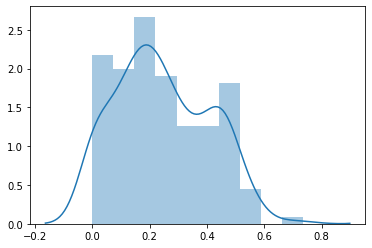

In [55]:
import seaborn as sns
sns.distplot(scores)

In [115]:
#TODO: also need to take into account the isomers, so need to calculate the formula
good_scores = []
bad_scores = []
minim = 1
for i, row in annotated_data_with_spectra.iterrows():
    standards = str(row['standards_match']).lower()
    hmdb = row['matchesHMDB']
    for h in hmdb:
        score = h[1]
        if h[0] != 0:
            name = metabolites[h[0]][2].lower()
            #get the scores for metabolites matching the standards annotation
            if name == standards:
                if score < minim:
                    minim = score
                good_scores.append(score)
            
            #get the scores for metabolites not matching with the standards annotation
            if standards != 'nan':
                
                if name != standards:
                    #print(standards,i, name, score)
                    if '-' in standards:
                        basestd = standards.split('-')[-1]
                        basename = name.split('-')[-1]
                    if not (basestd == basename or basestd in basename):
                        #print('\t', basestd, basename)
                        #print('\t',standards,i, name, score)
                        bad_scores.append(score)
                    
        
print('Lowest score value for which the HMDB annotation matches with the ToxID annotation:',minim)

Lowest score value for which the HMDB annotation matches with the ToxID annotation: 0.35362503743070683


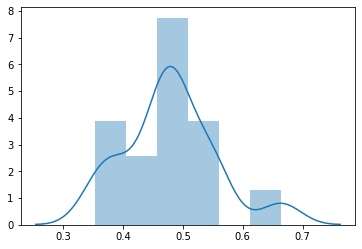

In [80]:
sns.distplot(good_scores)

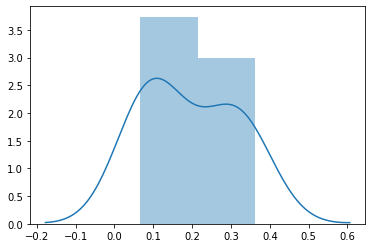

In [113]:
sns.distplot(bad_scores)

In [44]:
def plot_mirror(normalised_peaks_top, normalised_peaks_bottom):
    
    import matplotlib.pyplot as plt
    fig, axs = plt.subplots(2, sharex=True, sharey=False, gridspec_kw={'hspace': 0})

    for mz,intensity in normalised_peaks_top:
        axs[0].plot([mz,mz], [0,intensity], 'k')
    
    for mz,intensity in normalised_peaks_bottom:
        axs[1].plot([mz,mz],[0,-intensity],'k')
   
    # Hide x labels and tick labels for all but bottom plot.
    for ax in axs:
        ax.label_outer()
    plt.show()    
    


1401
nan
[('HMDB0014988', 0.10091398134601763, <mnet.Spectrum object at 0x1207caa20>), ('HMDB0000210', 0.14256955298719487, <mnet.Spectrum object at 0x11edbbba8>)]
('403.969', 'C21H26ClN3OS', 'Perphenazine')
('219.235', 'C9H17NO5', 'Pantothenic acid')


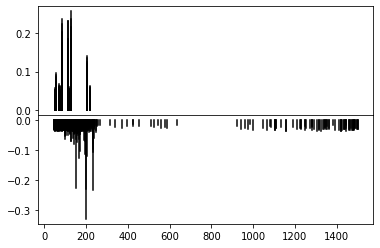

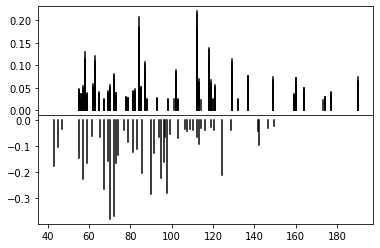

----
2664
nan
[('HMDB0015325', 0.04792514380900029, <mnet.Spectrum object at 0x121c317b8>), ('HMDB0015325', 0.05695032781857811, <mnet.Spectrum object at 0x11edbb7b8>), ('HMDB0015325', 0.06058433053650284, <mnet.Spectrum object at 0x122aae128>)]
('383.507', 'C12H21N3O5S3', 'Brinzolamide')
('383.507', 'C12H21N3O5S3', 'Brinzolamide')
('383.507', 'C12H21N3O5S3', 'Brinzolamide')


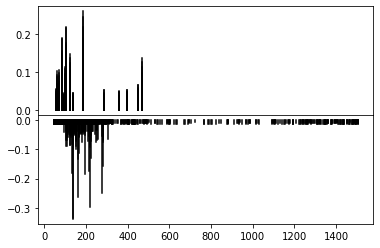

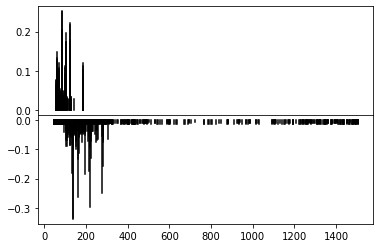

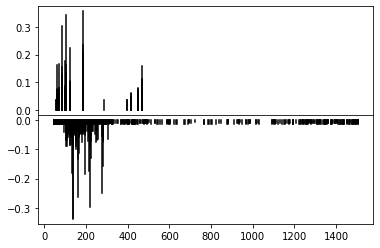

----
613
nan
[('HMDB0000641', 0.47978524104955117, <mnet.Spectrum object at 0x1213a15c0>), ('HMDB0000641', 0.47978524104955117, <mnet.Spectrum object at 0x11f08ef28>)]
('146.1445', 'C5H10N2O3', 'L-Glutamine')
('146.1445', 'C5H10N2O3', 'L-Glutamine')


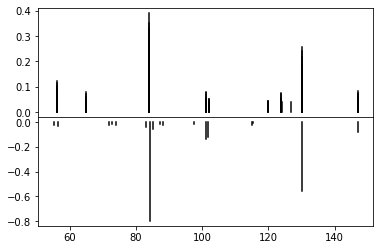

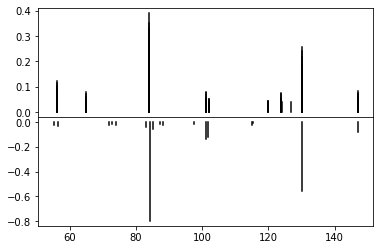

----
324
nan
[('HMDB0000479', 0.015941508107824173, <mnet.Spectrum object at 0x122aaea58>), ('HMDB0000251', 0.27664475373310216, <mnet.Spectrum object at 0x1207caa58>)]
('169.1811', 'C7H11N3O2', '3-Methylhistidine')
('125.147', 'C2H7NO3S', 'Taurine')


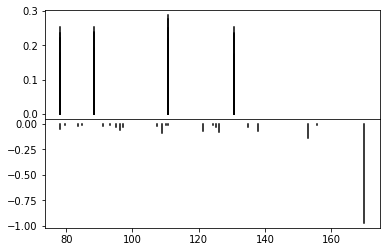

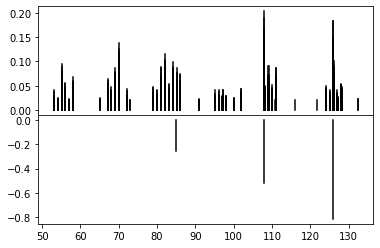

----
3108
nan
[(0, 0, 0)]
----
2989
nan
[(0, 0, 0), (0, 0, 0)]
----
2936
nan
[(0, 0, 0), (0, 0, 0)]
----
2980
nan
[(0, 0, 0)]
----
2960
nan
[(0, 0, 0)]
----
2995
nan
[(0, 0, 0)]
----
365
nan
[('HMDB0001921', 0.18707057446317832, <mnet.Spectrum object at 0x1213a12e8>)]
('129.1636', 'C4H11N5', '1,1-Dimethylbiguanide')


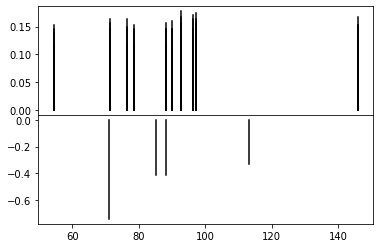

----
3025
nan
[(0, 0, 0)]
----
1993
sn-glycero-3-Phosphocholine
[('HMDB0015576', 0.1310692376203601, <mnet.Spectrum object at 0x1207ca438>), ('HMDB0014695', 0.14199269357379657, <mnet.Spectrum object at 0x11ee27a20>)]
('189.218', 'C6H12N3PS', 'Thiotepa')
('256.091', 'C9H7Cl2N5', 'Lamotrigine')


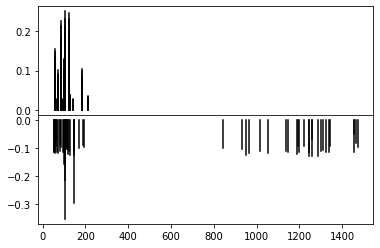

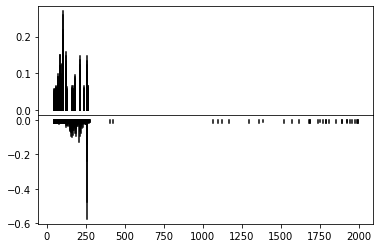

----
2997
nan
[(0, 0, 0)]
----
2915
nan
[(0, 0, 0)]
----
2722
nan
[('HMDB0014984', 0.10517573271824704, <mnet.Spectrum object at 0x121242be0>)]
('436.5136', 'C24H33FO6', 'Flurandrenolide')


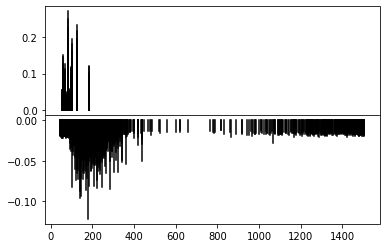

----
2693
nan
[('HMDB0015595', 0.07787479224914862, <mnet.Spectrum object at 0x123539470>)]
('529.5158', 'C28H22F3N7O', 'Nilotinib')


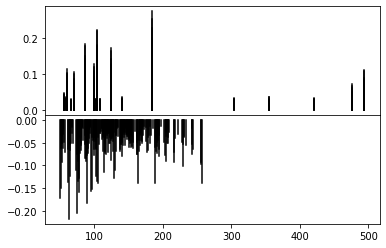

----
2744
nan
[('HMDB0015016', 0.13881823500952442, <mnet.Spectrum object at 0x1211a6550>), ('HMDB0015016', 0.14775657142352916, <mnet.Spectrum object at 0x11ff43668>)]
('505.447', 'C22H30Cl2N10', 'Chlorhexidine')
('505.447', 'C22H30Cl2N10', 'Chlorhexidine')


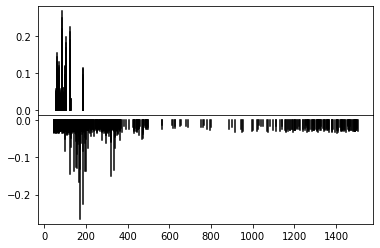

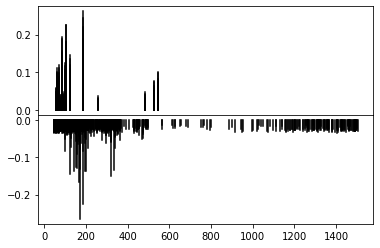

----
2720
nan
[('HMDB0014323', 0.04732516846466244, <mnet.Spectrum object at 0x121aa9c50>), ('HMDB0014323', 0.04209665368785074, <mnet.Spectrum object at 0x11e8f8358>)]
('435.5188', 'C24H29N5O3', 'Valsartan')
('435.5188', 'C24H29N5O3', 'Valsartan')


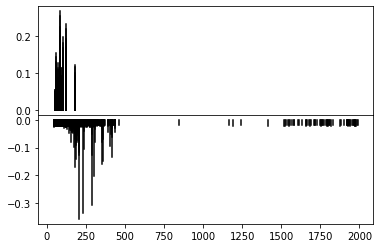

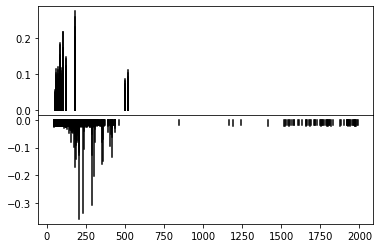

----
1787
nan
[('HMDB0015229', 0.21644248482950174, <mnet.Spectrum object at 0x11edbb5c0>)]
('270.2073', 'C12H9F3N2O2', 'Leflunomide')


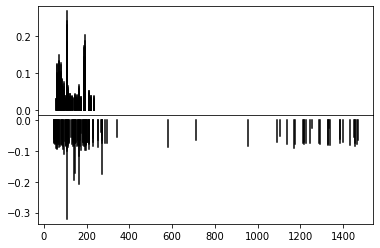

----
2114
nan
[('HMDB0015491', 0.11632787857187615, <mnet.Spectrum object at 0x1216b1828>)]
('190.1555', 'C9H6N2O3', 'Nitroxoline')


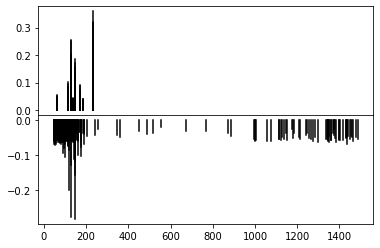

----
2958
nan
[(0, 0, 0)]
----
1419
O-Acetylcarnitine
[('HMDB0000472', 0.2645830603049031, <mnet.Spectrum object at 0x11edbbc50>), ('HMDB0000472', 0.30928836333069604, <mnet.Spectrum object at 0x11e8f8080>)]
('220.2246', 'C11H12N2O3', '5-Hydroxy-L-tryptophan')
('220.2246', 'C11H12N2O3', '5-Hydroxy-L-tryptophan')


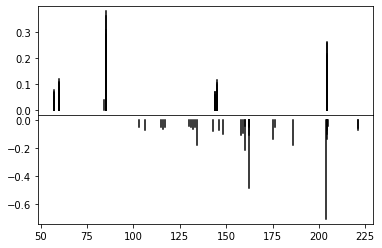

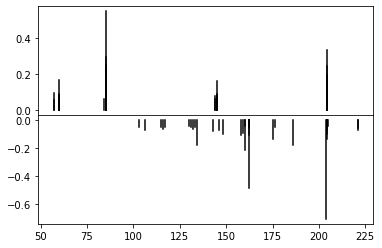

----
2942
nan
[(0, 0, 0), (0, 0, 0)]
----
602
nan
[('HMDB0001257', 0.2140516629067437, <mnet.Spectrum object at 0x122aaef98>)]
('145.2459', 'C7H19N3', 'Spermidine')


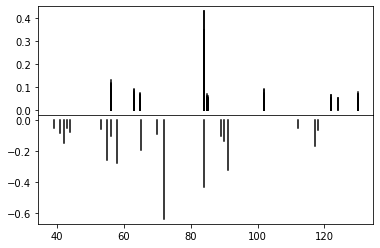

----
952
nan
[('HMDB0000670', 0.31654856105313567, <mnet.Spectrum object at 0x11ff433c8>)]
('188.2275', 'C7H16N4O2', 'Homo-L-arginine')


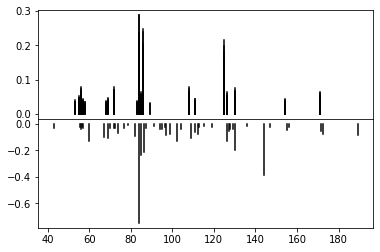

----
253
nan
[('HMDB0000034', 0.12236559431728594, <mnet.Spectrum object at 0x1211a62b0>)]
('135.1267', 'C5H5N5', 'Adenine')


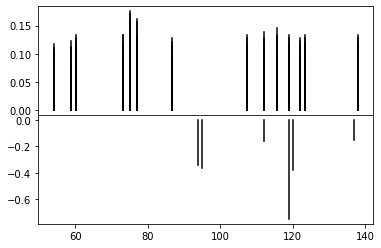

----
1100
nan
[('HMDB0001860', 0.43055938742146593, <mnet.Spectrum object at 0x1225e8f60>), ('HMDB0000714', 0.36585623201621625, <mnet.Spectrum object at 0x1213a1d68>), ('HMDB0001860', 0.43055938742146593, <mnet.Spectrum object at 0x11e8f8fd0>)]
('180.164', 'C7H8N4O2', 'Paraxanthine')
('179.1727', 'C9H9NO3', 'Hippuric acid')
('180.164', 'C7H8N4O2', 'Paraxanthine')


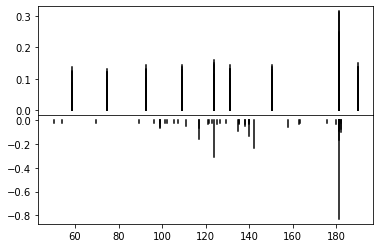

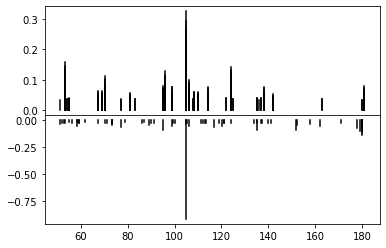

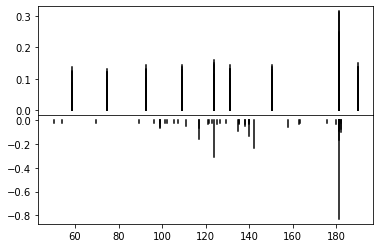

----
2724
nan
[('HMDB0014809', 0.1294808763485444, <mnet.Spectrum object at 0x11e8a14a8>)]
('453.45', 'C16H15N5O7S2', 'Cefixime')


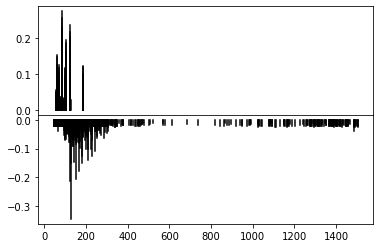

----
366
5-Oxoproline
[('HMDB0000897', 0.08628637561716006, <mnet.Spectrum object at 0x1216b1ba8>), ('HMDB0000070', 0.36276145491431677, <mnet.Spectrum object at 0x1211a6a90>)]
('165.1527', 'C6H7N5O', '7-Methylguanine')
('129.157', 'C6H11NO2', 'Pipecolic acid')


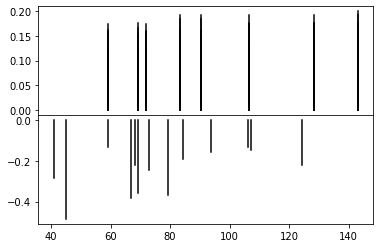

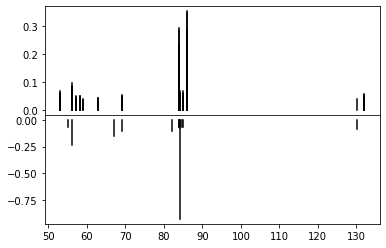

----
2830
nan
[('HMDB0004158', 0.0031688570081651437, <mnet.Spectrum object at 0x11fb6acc0>)]
('590.7098', 'C33H42N4O6', 'D-Urobilinogen')


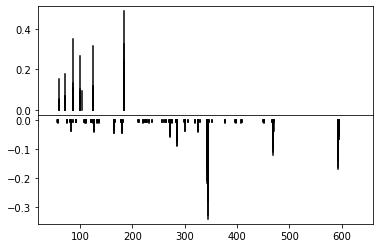

----
1150
nan
[('HMDB0001923', 0.15019830570490864, <mnet.Spectrum object at 0x1236d6898>), ('HMDB0001547', 0.19260219951730284, <mnet.Spectrum object at 0x11ee271d0>), ('HMDB0001923', 0.15019830570490864, <mnet.Spectrum object at 0x11e8f8320>)]
('230.2592', 'C14H14O3', 'Naproxen')
('346.4605', 'C21H30O4', 'Corticosterone')
('230.2592', 'C14H14O3', 'Naproxen')


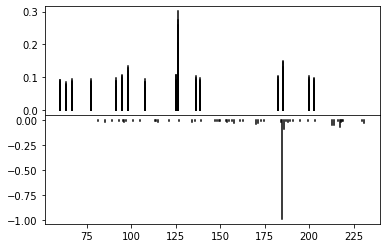

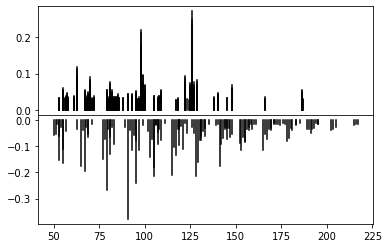

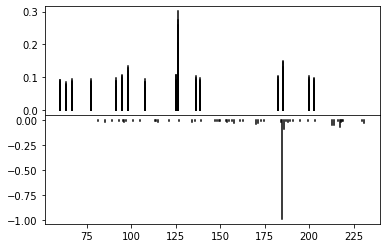

----
2897
nan
[(0, 0, 0)]
----
662
nan
[('HMDB0000897', 0.2948052876147232, <mnet.Spectrum object at 0x121aa9e48>)]
('165.1527', 'C6H7N5O', '7-Methylguanine')


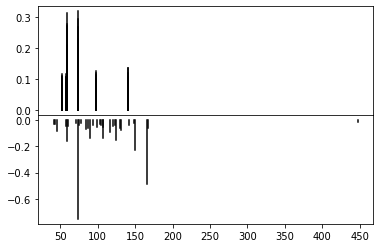

----
714
nan
[('HMDB0001859', 0.3875154807774372, <mnet.Spectrum object at 0x1213a1780>)]
('151.1626', 'C8H9NO2', 'Acetaminophen')


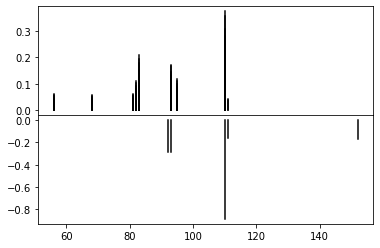

----
2696
nan
[('HMDB0015152', 0.10215913898609241, <mnet.Spectrum object at 0x1211a6c50>)]
('457.4764', 'C23H27N3O7', 'Minocycline')


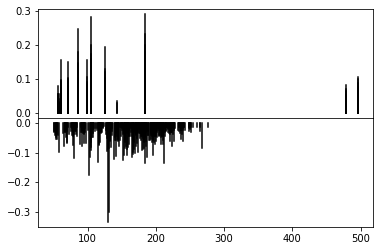

----
2678
nan
[('HMDB0015481', 0.044775164992212034, <mnet.Spectrum object at 0x121d6de10>)]
('481.5026', 'C27H23N5O4', 'Pranlukast')


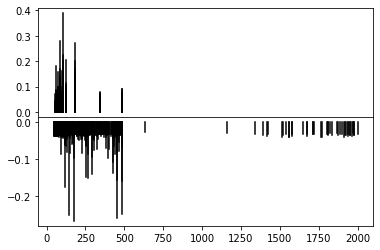

----
2923
nan
[(0, 0, 0)]
----
2711
nan
[('HMDB0014728', 0.014146366441248637, <mnet.Spectrum object at 0x121aa94e0>)]
('451.4751', 'C23H25N5O5', 'Doxazosin')


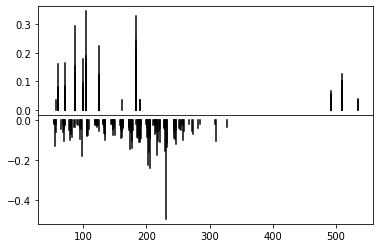

----
459
Methylcysteine
[('HMDB0014328', 0.3166627294047758, <mnet.Spectrum object at 0x120fb9dd8>)]
('135.2062', 'C9H13N', 'Amphetamine')


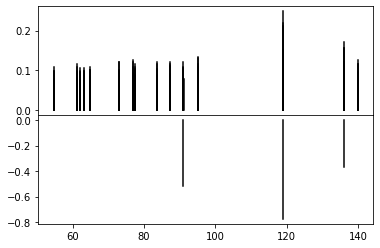

----
785
nan
[('HMDB0001522', 0.27092947172356924, <mnet.Spectrum object at 0x122aaee10>)]
('73.0971', 'C2H7N3', 'Methylguanidine')


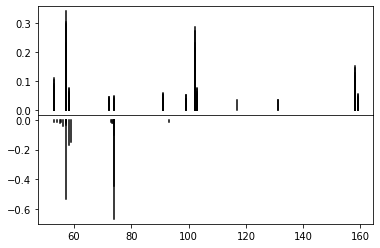

----
1463
L-Kynurenine
[('HMDB0000684', 0.35362503743070683, <mnet.Spectrum object at 0x120fb9390>)]
('208.2139', 'C10H12N2O3', 'L-Kynurenine')


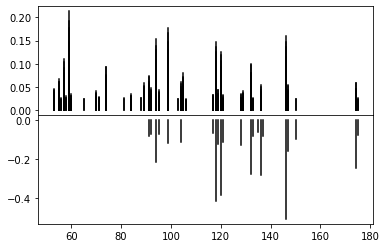

----
1229
nan
[('HMDB0002302', 0.391234684102284, <mnet.Spectrum object at 0x120babcf8>), ('HMDB0002302', 0.391234684102284, <mnet.Spectrum object at 0x11fb6ac50>)]
('189.2105', 'C11H11NO2', 'Indole-3-propionic acid')
('189.2105', 'C11H11NO2', 'Indole-3-propionic acid')


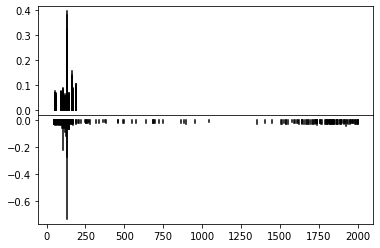

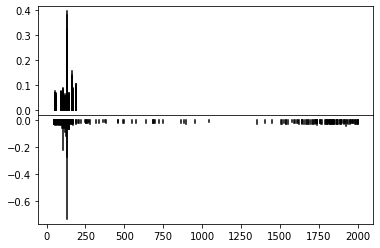

----
1360
nan
[('HMDB0001889', 0.27685539528327624, <mnet.Spectrum object at 0x1225e8470>)]
('180.164', 'C7H8N4O2', 'Theophylline')


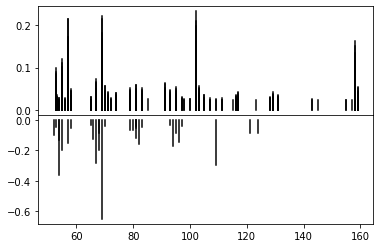

----
2322
nan
[('HMDB0014694', 0.18726140771081537, <mnet.Spectrum object at 0x11ff43c50>), ('HMDB0014694', 0.28789119969291666, <mnet.Spectrum object at 0x1225e85c0>)]
('331.346', 'C15H13N3O4S', 'Piroxicam')
('331.346', 'C15H13N3O4S', 'Piroxicam')


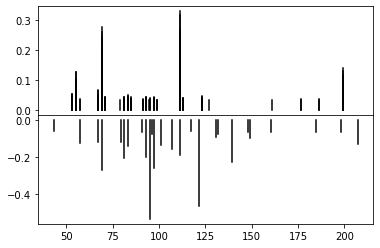

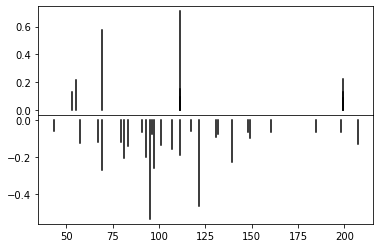

----
667
L-Methionine
[('HMDB0000696', 0.3820775216338705, <mnet.Spectrum object at 0x11ee27438>), ('HMDB0000696', 0.3820775216338705, <mnet.Spectrum object at 0x11fe9e9e8>)]
('149.211', 'C5H11NO2S', 'L-Methionine')
('149.211', 'C5H11NO2S', 'L-Methionine')


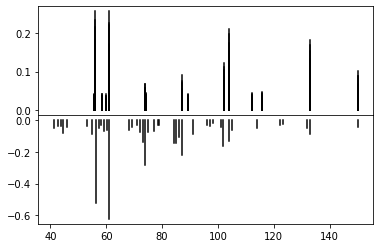

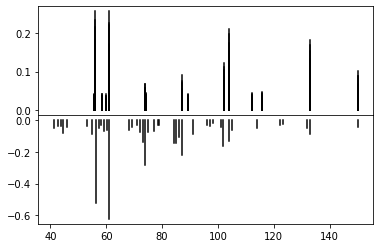

----
264
nan
[('HMDB0000159', 0.4159010712623952, <mnet.Spectrum object at 0x11ff434e0>), ('HMDB0000159', 0.42431017920405595, <mnet.Spectrum object at 0x121aa9748>)]
('165.1891', 'C9H11NO2', 'L-Phenylalanine')
('165.1891', 'C9H11NO2', 'L-Phenylalanine')


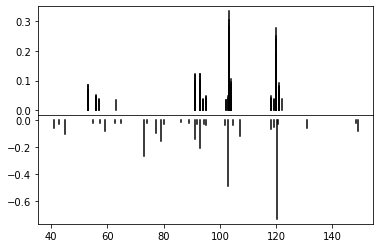

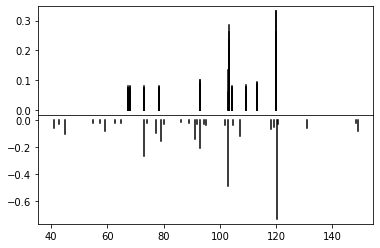

----
1359
nan
[('HMDB0001889', 0.5445123117340067, <mnet.Spectrum object at 0x1216b1978>)]
('180.164', 'C7H8N4O2', 'Theophylline')


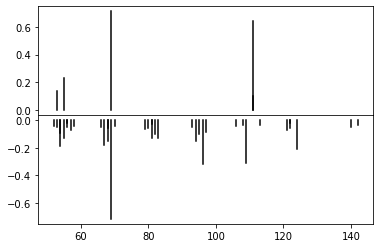

----
2230
nan
[('HMDB0014395', 0.16945125243178488, <mnet.Spectrum object at 0x11fb6ad30>)]
('248.301', 'C12H12N2O2S', 'Dapsone')


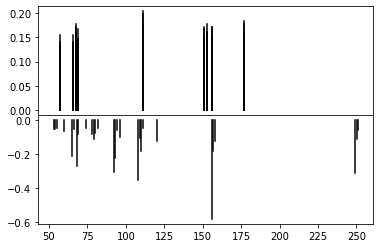

----
895
L-Phenylalanine
[('HMDB0000159', 0.45601214719441485, <mnet.Spectrum object at 0x121dd2588>), ('HMDB0000159', 0.47783559195514846, <mnet.Spectrum object at 0x11fe9ef28>)]
('165.1891', 'C9H11NO2', 'L-Phenylalanine')
('165.1891', 'C9H11NO2', 'L-Phenylalanine')


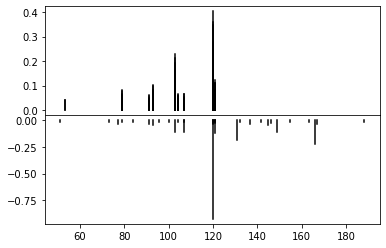

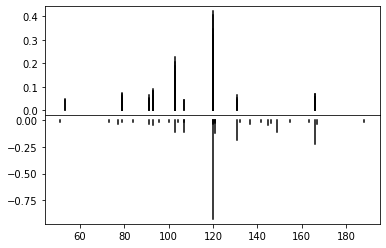

----
38
nan
[('HMDB0000070', 0.4146837308024526, <mnet.Spectrum object at 0x121242e80>)]
('129.157', 'C6H11NO2', 'Pipecolic acid')


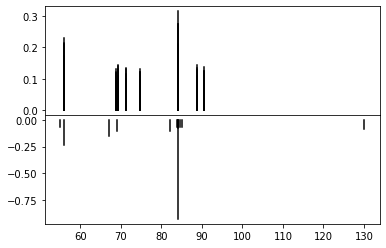

----
2151
nan
[('HMDB0000194', 0.24594820380791443, <mnet.Spectrum object at 0x121242470>), ('HMDB0014724', 0.25069462713711715, <mnet.Spectrum object at 0x11e8a1390>)]
('240.259', 'C10H16N4O3', 'Anserine')
('296.149', 'C14H11Cl2NO2', 'Diclofenac')


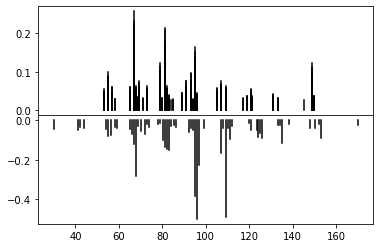

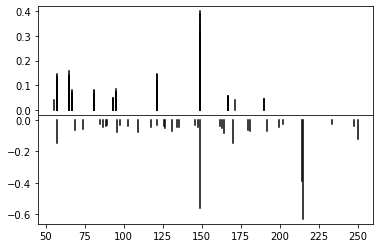

----
166
nan
[('HMDB0002434', 0.5583687776694077, <mnet.Spectrum object at 0x121c314e0>)]
('110.1106', 'C6H6O2', 'Hydroquinone')


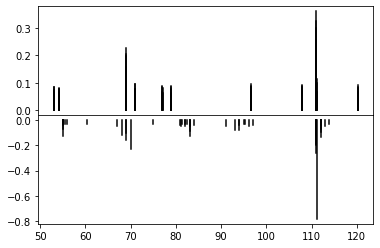

----
2779
nan
[('HMDB0014351', 0.14391008973172656, <mnet.Spectrum object at 0x120fb9780>), ('HMDB0014351', 0.14391008973172656, <mnet.Spectrum object at 0x11ff43860>)]
('608.6787', 'C33H40N2O9', 'Reserpine')
('608.6787', 'C33H40N2O9', 'Reserpine')


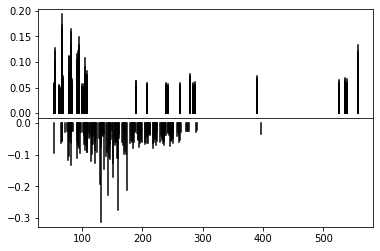

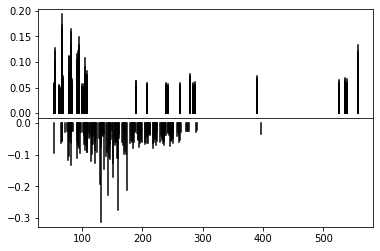

----
626
nan
[('HMDB0000017', 0.2304642067081969, <mnet.Spectrum object at 0x11fb6a198>)]
('183.1614', 'C8H9NO4', '4-Pyridoxic acid')


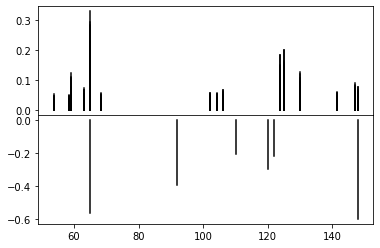

----
2051
nan
[('HMDB0000684', 0.24639564214363713, <mnet.Spectrum object at 0x1207ca630>)]
('208.2139', 'C10H12N2O3', 'L-Kynurenine')


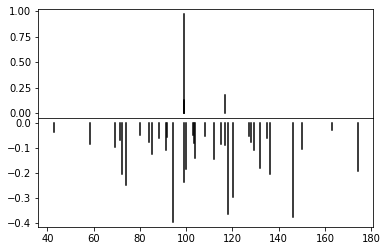

----
535
nan
[('HMDB0014375', 0.38403473731922333, <mnet.Spectrum object at 0x11e8f8a58>)]
('159.2261', 'C8H17NO2', 'Pregabalin')


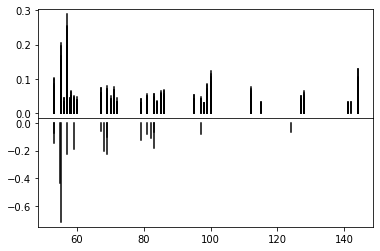

----
125
nan
[('HMDB0000650', 0.40273250989863446, <mnet.Spectrum object at 0x11edbb630>), ('HMDB0000650', 0.7347313950944477, <mnet.Spectrum object at 0x121aa9080>)]
('103.1198', 'C4H9NO2', 'D-alpha-Aminobutyric acid')
('103.1198', 'C4H9NO2', 'D-alpha-Aminobutyric acid')


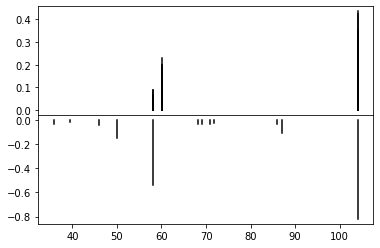

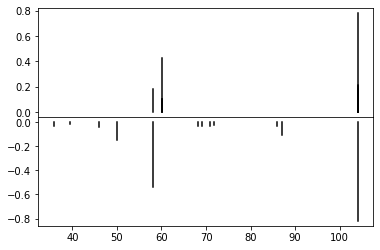

----
2842
nan
[(0, 0, 0)]
----
726
nan
[('HMDB0000152', 0.17949572296694688, <mnet.Spectrum object at 0x11fe9e048>)]
('154.121', 'C7H6O4', 'Gentisic acid')


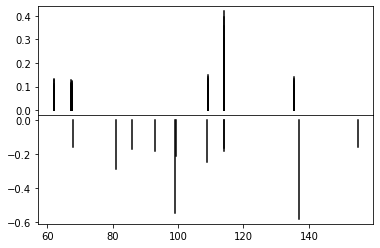

----
1591
nan
[('HMDB0015328', 0.14386133299559375, <mnet.Spectrum object at 0x11e8f89e8>)]
('217.285', 'C9H15NO3S', 'Captopril')


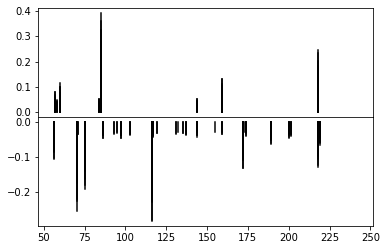

----
2716
nan
[('HMDB0014826', 0.014657744427757571, <mnet.Spectrum object at 0x11e8a1a58>)]
('433.4947', 'C23H31NO7', 'Mycophenolate mofetil')


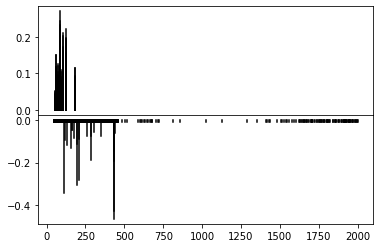

----
2629
nan
[('HMDB0014682', 0.10900145450297456, <mnet.Spectrum object at 0x1236d6278>)]
('424.4895', 'C24H28N2O5', 'Benazepril')


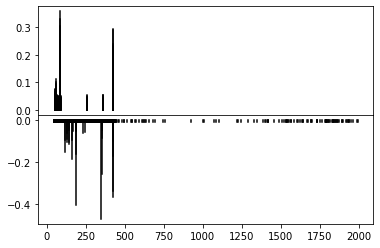

----
915
nan
[('HMDB0014748', 0.322229394448621, <mnet.Spectrum object at 0x121242400>), ('HMDB0002182', 0.4510189461057069, <mnet.Spectrum object at 0x120c80080>)]
('167.205', 'C9H13NO2', 'Metaraminol')
('167.205', 'C9H13NO2', 'Phenylephrine')


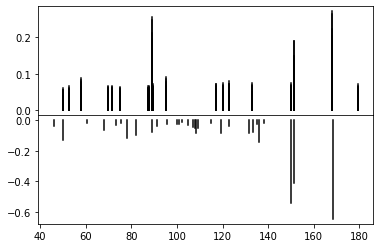

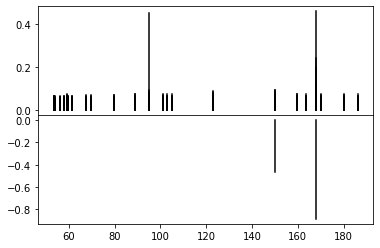

----
298
nan
[('HMDB0001406', 0.48447439857309677, <mnet.Spectrum object at 0x11edbb6a0>), ('HMDB0001406', 0.48447439857309677, <mnet.Spectrum object at 0x1236d6f60>)]
('122.1246', 'C6H6N2O', 'Niacinamide')
('122.1246', 'C6H6N2O', 'Niacinamide')


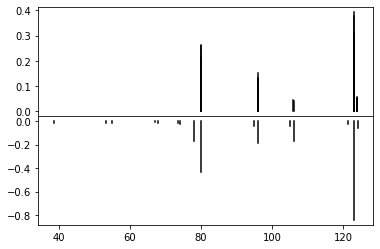

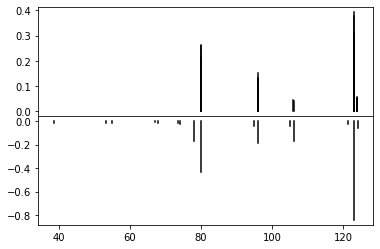

----
1089
nan
[('HMDB0015009', 0.17199006459515304, <mnet.Spectrum object at 0x11fb6a240>), ('HMDB0015177', 0.18691775064392835, <mnet.Spectrum object at 0x1213a1a90>)]
('225.2842', 'C12H19NO3', 'Terbutaline')
('179.3018', 'C12H21N', 'Memantine')


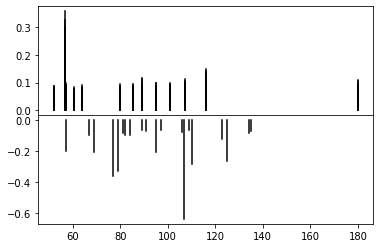

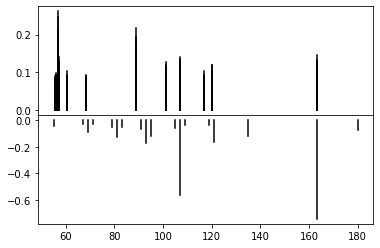

----
1901
nan
[('HMDB0000684', 0.24134813168121025, <mnet.Spectrum object at 0x122aae358>), ('HMDB0000684', 0.2951684353080986, <mnet.Spectrum object at 0x121aa9588>), ('HMDB0000684', 0.24134813168121025, <mnet.Spectrum object at 0x121c31ef0>)]
('208.2139', 'C10H12N2O3', 'L-Kynurenine')
('208.2139', 'C10H12N2O3', 'L-Kynurenine')
('208.2139', 'C10H12N2O3', 'L-Kynurenine')


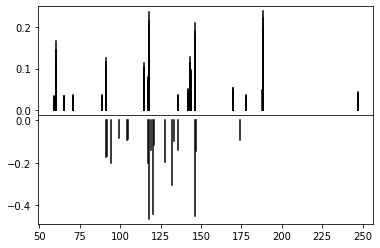

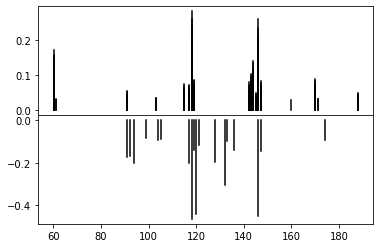

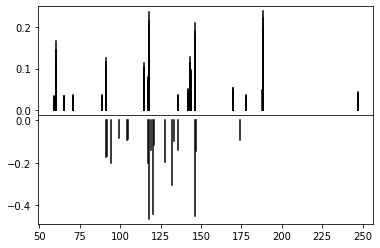

----
862
nan
[('HMDB0001964', 0.3680834042801341, <mnet.Spectrum object at 0x1225e8630>)]
('180.1574', 'C9H8O4', 'Caffeic acid')


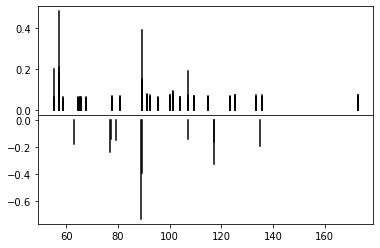

----
614
nan
[('HMDB0005809', 0.23599619604101577, <mnet.Spectrum object at 0x120c801d0>)]
('164.2011', 'C10H12O2', 'Eugenol')


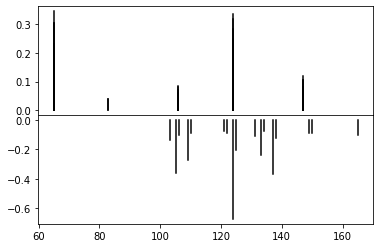

----
2796
nan
[('HMDB0015381', 0.039347326763102805, <mnet.Spectrum object at 0x1225e8518>)]
('527.632', 'C27H33N3O6S', 'Gliquidone')


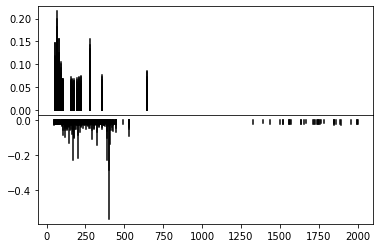

----
2667
nan
[('HMDB0015138', 0.07492059665503058, <mnet.Spectrum object at 0x120fb9cc0>)]
('468.3665', 'C23H16O11', 'Cromoglicic acid')


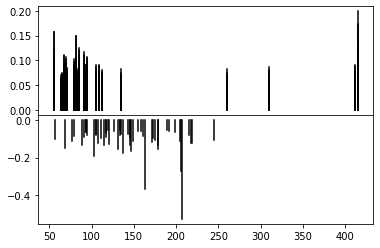

----
2743
nan
[('HMDB0015152', 0.07576496462053076, <mnet.Spectrum object at 0x11e8f88d0>)]
('457.4764', 'C23H27N3O7', 'Minocycline')


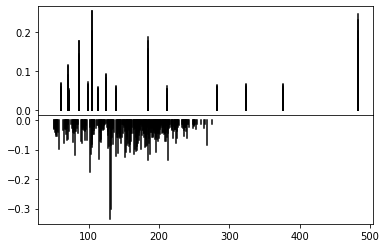

----
2940
nan
[(0, 0, 0)]
----
1468
nan
[('HMDB0015144', 0.3329871993900353, <mnet.Spectrum object at 0x1236d6630>)]
('254.2806', 'C16H14O3', 'Ketoprofen')


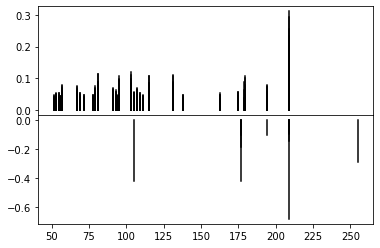

----
2451
nan
[('HMDB0014951', 0.24516752794941848, <mnet.Spectrum object at 0x1213a1710>), ('HMDB0014444', 0.20201660984839592, <mnet.Spectrum object at 0x11ee27128>)]
('336.4705', 'C22H28N2O', 'Fentanyl')
('253.2578', 'C10H15N5O3', 'Penciclovir')


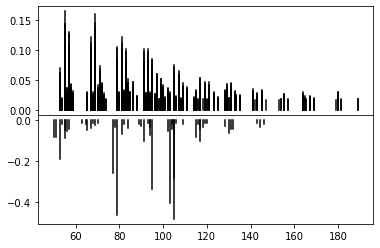

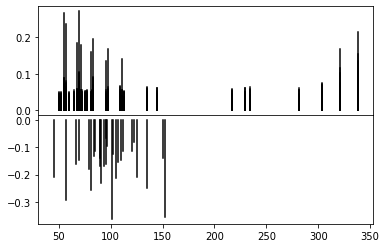

----
2726
nan
[('HMDB0015016', 0.16485760529262594, <mnet.Spectrum object at 0x11f89e5f8>)]
('505.447', 'C22H30Cl2N10', 'Chlorhexidine')


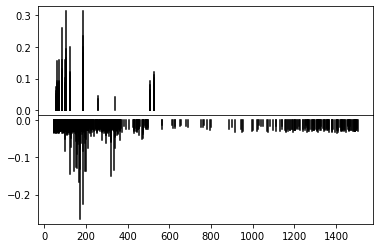

----
737
nan
[('HMDB0000177', 0.4576470901474791, <mnet.Spectrum object at 0x11ff430f0>), ('HMDB0000177', 0.4576470901474791, <mnet.Spectrum object at 0x1225e8b38>)]
('155.1546', 'C6H9N3O2', 'L-Histidine')
('155.1546', 'C6H9N3O2', 'L-Histidine')


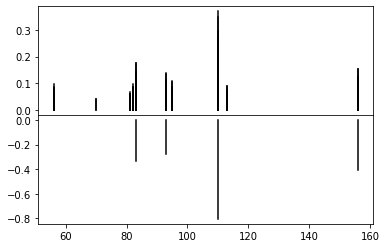

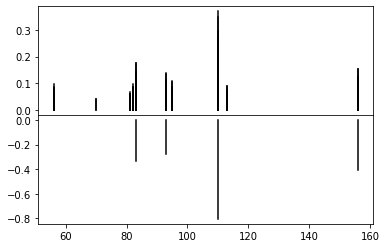

----
63
nan
[('HMDB0000168', 0.3261491174926002, <mnet.Spectrum object at 0x11fe9e4e0>)]
('132.1179', 'C4H8N2O3', 'L-Asparagine')


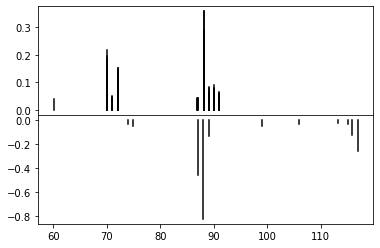

----
3642
nan
[('HMDB0000714', 0.4701410291433636, <mnet.Spectrum object at 0x11fb6a978>), ('HMDB0000714', 0.39062858969024583, <mnet.Spectrum object at 0x11ee27668>)]
('179.1727', 'C9H9NO3', 'Hippuric acid')
('179.1727', 'C9H9NO3', 'Hippuric acid')


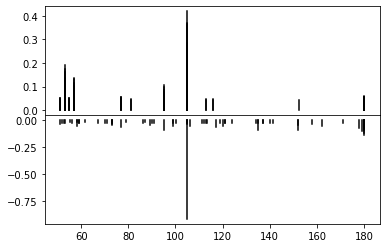

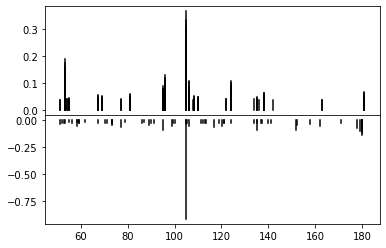

----
424
nan
[('HMDB0014935', 0.3124805156326093, <mnet.Spectrum object at 0x1213a1f28>), ('HMDB0000064', 0.470439438819249, <mnet.Spectrum object at 0x120fb9be0>)]
('160.2157', 'C10H12N2', 'Tolazoline')
('131.1332', 'C4H9N3O2', 'Creatine')


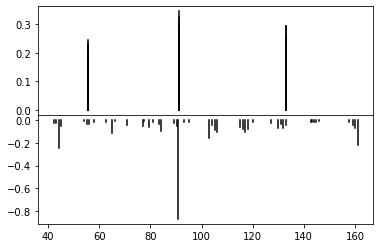

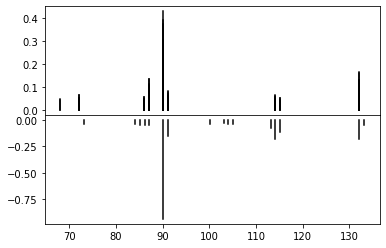

----
2757
nan
[('HMDB0014624', 0.0558001226361909, <mnet.Spectrum object at 0x11f89ef98>)]
('473.583', 'C28H27NO4S', 'Raloxifene')


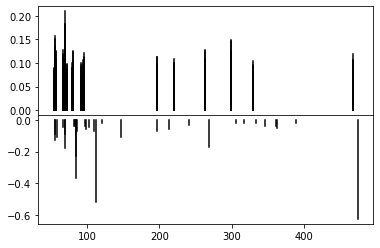

----
1754
nan
[('HMDB0001555', 0.21807208040734907, <mnet.Spectrum object at 0x120fb9320>)]
('248.173', 'C8H13N2O5P', "Pyridoxamine 5'-phosphate")


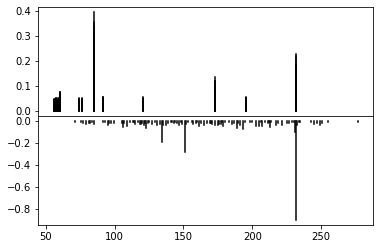

----
599
nan
[('HMDB0001257', 0.20986208445857846, <mnet.Spectrum object at 0x1207cac88>), ('HMDB0002243', 0.2326638262103878, <mnet.Spectrum object at 0x122aae828>)]
('145.2459', 'C7H19N3', 'Spermidine')
('123.1094', 'C6H5NO2', 'Picolinic acid')


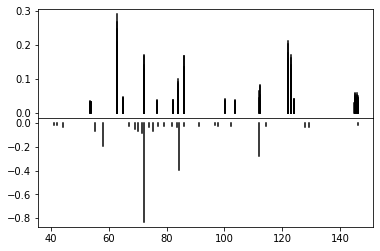

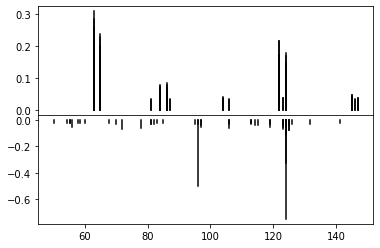

----
1405
nan
[('HMDB0042008', 0.1773916604477347, <mnet.Spectrum object at 0x1207cab38>)]
('219.2796', 'C13H17NO2', 'Ritalinic acid')


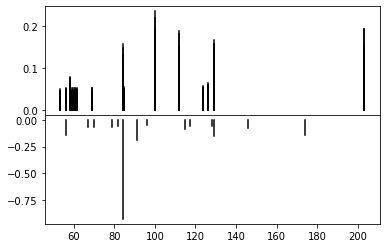

----
2803
nan
[('HMDB0014884', 0.017129493881001583, <mnet.Spectrum object at 0x11fb6ab70>), ('HMDB0014884', 0.017129493881001583, <mnet.Spectrum object at 0x121870f28>)]
('560.684', 'C25H48N6O8', 'Deferoxamine')
('560.684', 'C25H48N6O8', 'Deferoxamine')


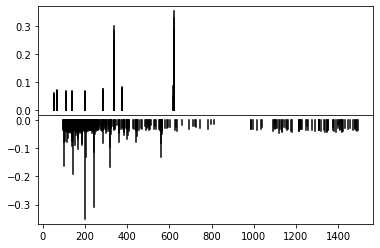

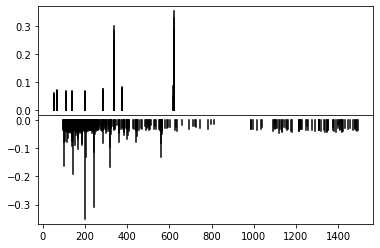

----
1189
nan
[('HMDB0000929', 0.3138779927140466, <mnet.Spectrum object at 0x122aae3c8>)]
('204.2252', 'C11H12N2O2', 'L-Tryptophan')


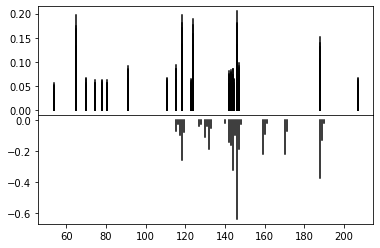

----
2799
nan
[('HMDB0015595', 0.1357363712973851, <mnet.Spectrum object at 0x11e867cc0>), ('HMDB0015595', 0.09554664073787082, <mnet.Spectrum object at 0x11edbb2b0>)]
('529.5158', 'C28H22F3N7O', 'Nilotinib')
('529.5158', 'C28H22F3N7O', 'Nilotinib')


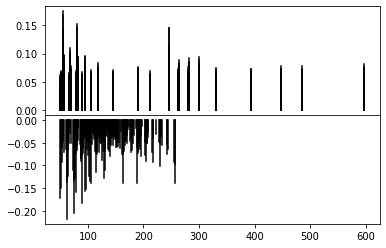

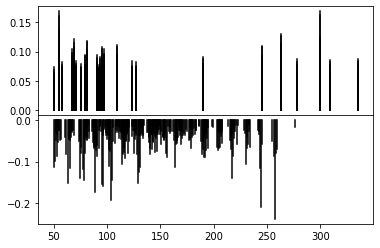

----
798
nan
[('HMDB0000904', 0.34814735458145457, <mnet.Spectrum object at 0x121d6dc18>)]
('175.1857', 'C6H13N3O3', 'Citrulline')


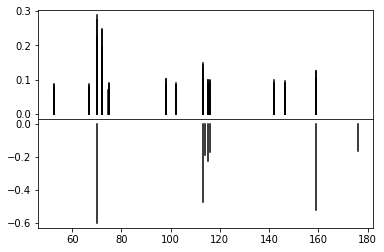

----
2289
nan
[('HMDB0015274', 0.18641994289029404, <mnet.Spectrum object at 0x1207ca908>)]
('214.223', 'C5H15N2O3PS', 'Amifostine')


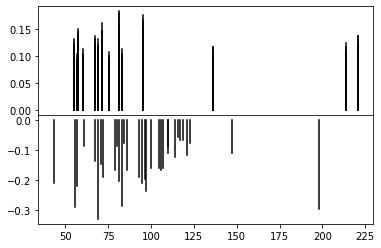

----
4343
nan
[('HMDB0014809', 0.12275130022783999, <mnet.Spectrum object at 0x11edbb940>)]
('453.45', 'C16H15N5O7S2', 'Cefixime')


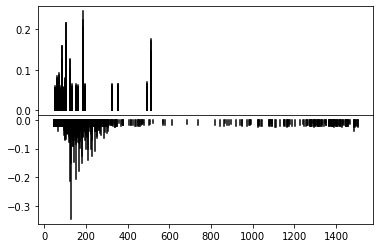

----
2371
nan
[('HMDB0014977', 0.11626205508711708, <mnet.Spectrum object at 0x1207caf60>)]
('311.4', 'C14H21N3O3S', 'Tolazamide')


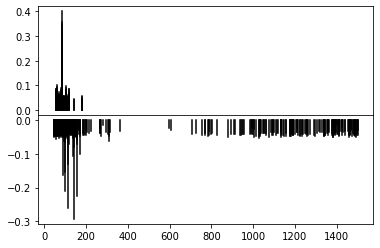

----
175
nan
[('HMDB0000562', 0.5602085409996662, <mnet.Spectrum object at 0x11fb6af28>), ('HMDB0000562', 0.553646821801809, <mnet.Spectrum object at 0x11e8a1e10>)]
('113.1179', 'C4H7N3O', 'Creatinine')
('113.1179', 'C4H7N3O', 'Creatinine')


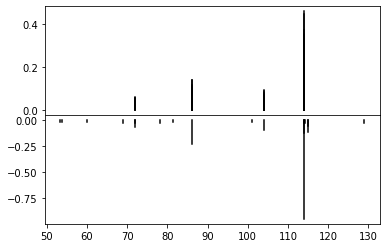

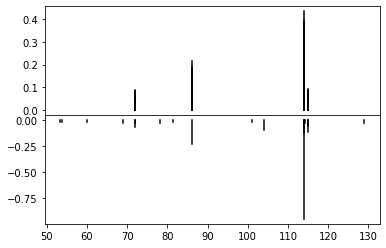

----
1439
L-Tryptophan
[('HMDB0013609', 0.4420753691629907, <mnet.Spectrum object at 0x1211a6908>), ('HMDB0000929', 0.46897660906244654, <mnet.Spectrum object at 0x121aa9ef0>), ('HMDB0013609', 0.4420753691629907, <mnet.Spectrum object at 0x1225e8278>)]
('204.2252', 'C11H12N2O2', 'D-Tryptophan')
('204.2252', 'C11H12N2O2', 'L-Tryptophan')
('204.2252', 'C11H12N2O2', 'D-Tryptophan')


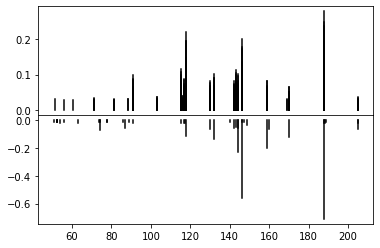

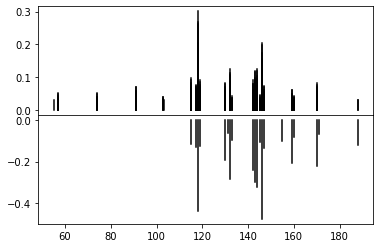

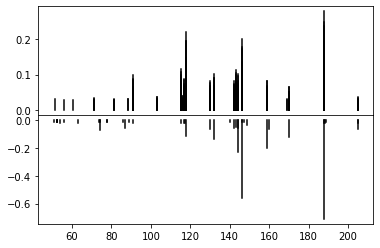

----
2763
nan
[('HMDB0015595', 0.09080025568144667, <mnet.Spectrum object at 0x121242ef0>)]
('529.5158', 'C28H22F3N7O', 'Nilotinib')


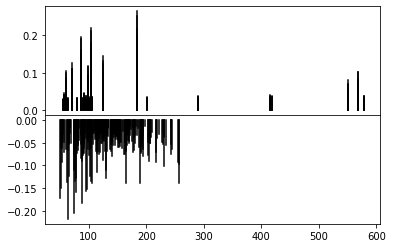

----
2861
nan
[(0, 0, 0)]
----
2863
nan
[(0, 0, 0)]
----
778
nan
[('HMDB0000893', 0.21725720175487684, <mnet.Spectrum object at 0x121870048>)]
('174.1944', 'C8H14O4', 'Suberic acid')


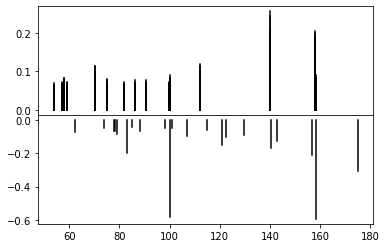

----
2392
nan
[('HMDB0001830', 0.23314916816763656, <mnet.Spectrum object at 0x1216b15f8>)]
('314.4617', 'C21H30O2', 'Progesterone')


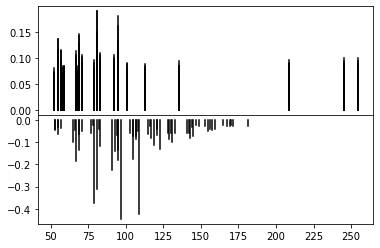

----
3867
nan
[('HMDB0014789', 0.1265369829926818, <mnet.Spectrum object at 0x1225e8e48>)]
('254.2426', 'C10H14N4O4', 'Dyphylline')


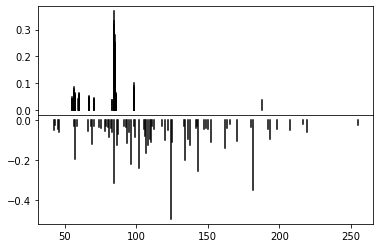

----
668
nan
[('HMDB0001645', 0.4678119596838144, <mnet.Spectrum object at 0x11e8f8780>)]
('131.1729', 'C6H13NO2', 'L-Norleucine')


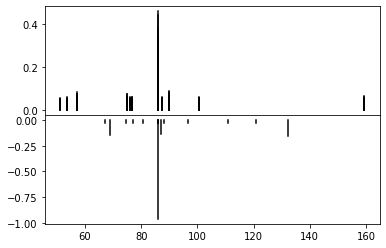

----
134
nan
[('HMDB0000112', 0.394846952993414, <mnet.Spectrum object at 0x121dd20b8>)]
('103.1198', 'C4H9NO2', 'gamma-Aminobutyric acid')


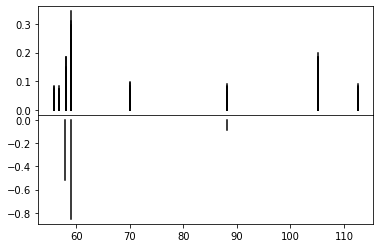

----
1037
L-Citrulline
[('HMDB0000904', 0.44453838666608575, <mnet.Spectrum object at 0x121dd2d30>)]
('175.1857', 'C6H13N3O3', 'Citrulline')


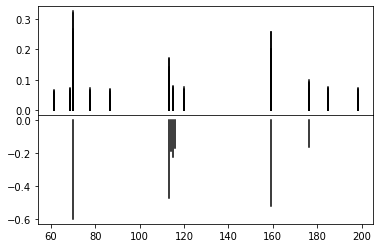

----
1149
nan
[('HMDB0014747', 0.13993076102593874, <mnet.Spectrum object at 0x1225e87f0>)]
('166.243', 'C8H10N2S', 'Ethionamide')


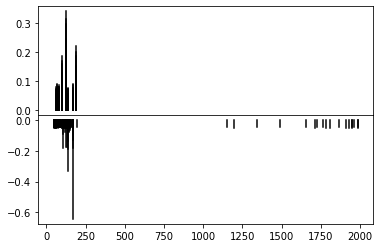

----
2855
nan
[(0, 0, 0)]
----
2824
nan
[(0, 0, 0), (0, 0, 0)]
----
2901
nan
[(0, 0, 0)]
----
2844
nan
[(0, 0, 0)]
----
1033
nan
[('HMDB0000197', 0.4277135871551896, <mnet.Spectrum object at 0x120fb9358>), ('HMDB0000197', 0.4277135871551896, <mnet.Spectrum object at 0x11e867dd8>)]
('175.184', 'C10H9NO2', 'Indoleacetic acid')
('175.184', 'C10H9NO2', 'Indoleacetic acid')


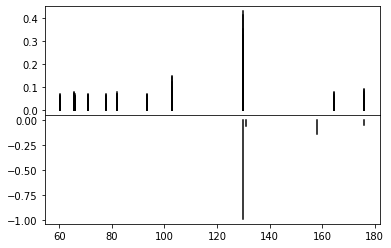

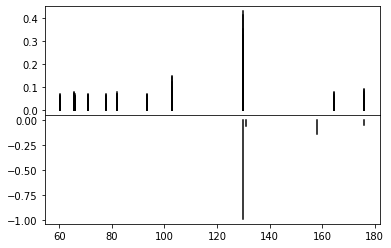

----
122
nan
[('HMDB0001906', 0.5501106020220621, <mnet.Spectrum object at 0x1211a6518>), ('HMDB0001906', 0.4408921295628998, <mnet.Spectrum object at 0x121242978>)]
('103.1198', 'C4H9NO2', '2-Aminoisobutyric acid')
('103.1198', 'C4H9NO2', '2-Aminoisobutyric acid')


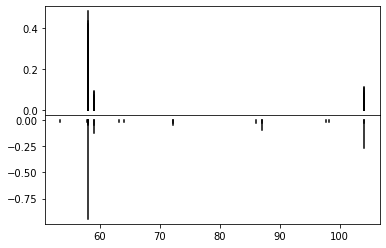

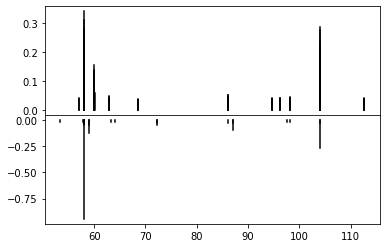

----
588
nan
[('HMDB0001879', 0.18803294242861632, <mnet.Spectrum object at 0x1216b1c88>)]
('180.1574', 'C9H8O4', 'Aspirin')


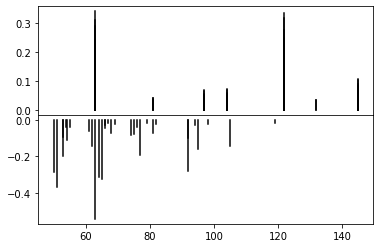

----
413
nan
[('HMDB0001645', 0.15108970209763173, <mnet.Spectrum object at 0x121870198>), ('HMDB0001522', 0.26857192516676226, <mnet.Spectrum object at 0x1207ca7b8>)]
('131.1729', 'C6H13NO2', 'L-Norleucine')
('73.0971', 'C2H7N3', 'Methylguanidine')


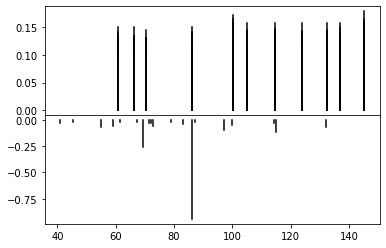

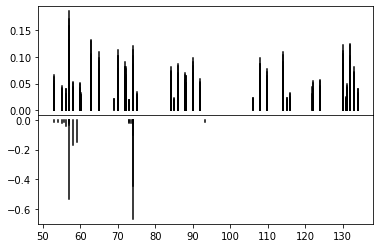

----
565
nan
[('HMDB0000715', 0.49705084494029333, <mnet.Spectrum object at 0x1218703c8>)]
('189.1675', 'C10H7NO3', 'Kynurenic acid')


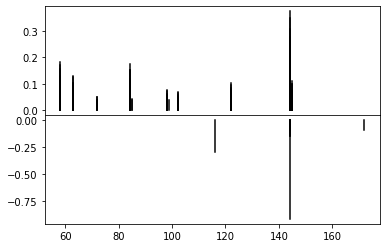

----
2469
nan
[('HMDB0014876', 0.11574556261754146, <mnet.Spectrum object at 0x1213a16d8>)]
('340.4195', 'C19H24N4O2', 'Pentamidine')


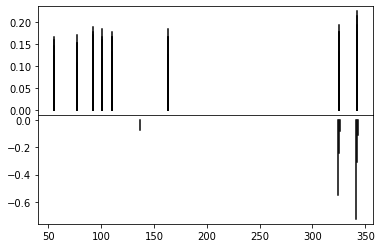

----
2834
nan
[(0, 0, 0)]
----
2225
nan
[('HMDB0014440', 0.2180044734138609, <mnet.Spectrum object at 0x121d6d470>)]
('285.3377', 'C17H19NO3', 'Morphine')


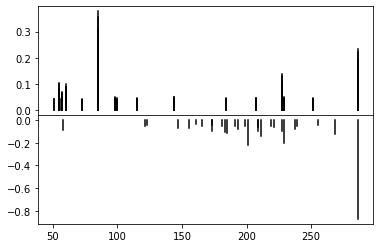

----
137
nan
[('HMDB0000097', 0.4971117166407742, <mnet.Spectrum object at 0x11fb6a908>)]
('104.1708', 'C5H14NO', 'Choline')


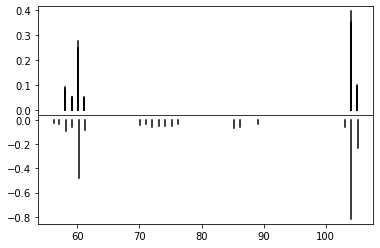

----
436
nan
[('HMDB0003640', 0.2231018616027859, <mnet.Spectrum object at 0x11e8f8978>)]
('131.1729', 'C6H13NO2', 'Beta-Leucine')


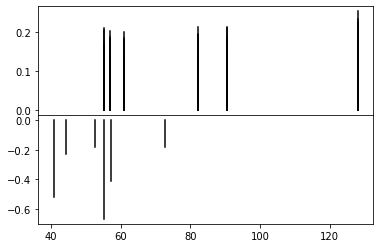

----
2234
nan
[('HMDB0000210', 0.18538639566943846, <mnet.Spectrum object at 0x11f89edd8>), ('HMDB0014578', 0.24990462265661012, <mnet.Spectrum object at 0x121dd2b70>)]
('219.235', 'C9H17NO5', 'Pantothenic acid')
('287.3981', 'C21H21N', 'Cyproheptadine')


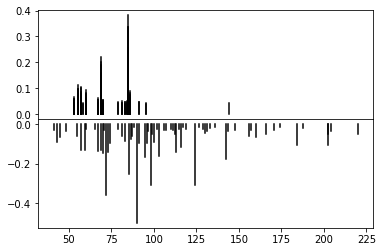

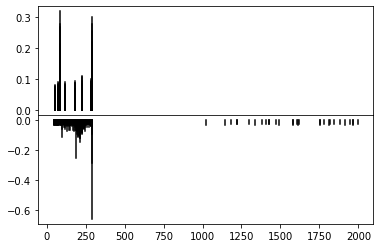

----
2680
nan
[('HMDB0001201', 0.026878897335313207, <mnet.Spectrum object at 0x121aa9cf8>), ('HMDB0015481', 0.05625746790161048, <mnet.Spectrum object at 0x121c311d0>)]
('443.2005', 'C10H15N5O11P2', 'Guanosine diphosphate')
('481.5026', 'C27H23N5O4', 'Pranlukast')


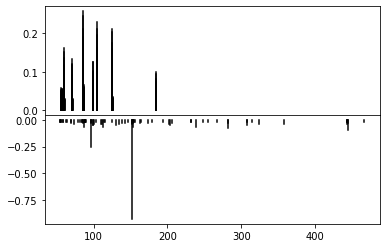

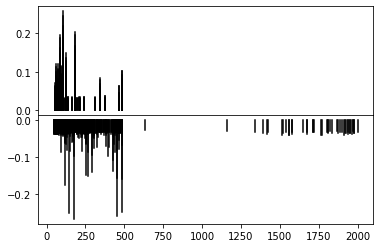

----
817
nan
[('HMDB0014375', 0.30931397971007646, <mnet.Spectrum object at 0x11edbb6d8>)]
('159.2261', 'C8H17NO2', 'Pregabalin')


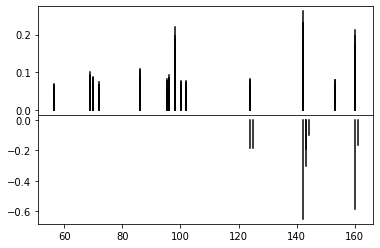

----
789
nan
[('HMDB0000904', 0.1744844302689266, <mnet.Spectrum object at 0x11e8f8588>)]
('175.1857', 'C6H13N3O3', 'Citrulline')


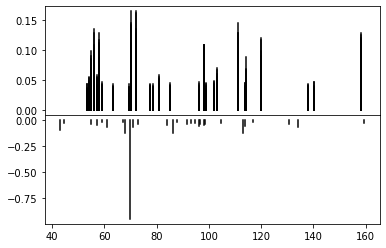

----
704
nan
[('HMDB0000786', 0.2927639316348824, <mnet.Spectrum object at 0x1216b1a20>), ('HMDB0000786', 0.26931877178176145, <mnet.Spectrum object at 0x11ff43dd8>)]
('152.1109', 'C5H4N4O2', 'Oxypurinol')
('152.1109', 'C5H4N4O2', 'Oxypurinol')


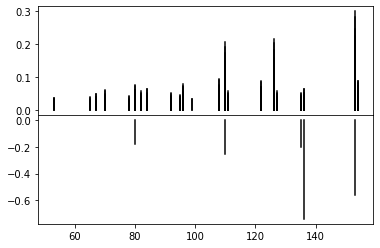

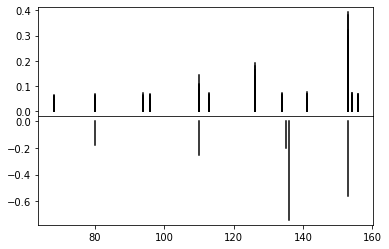

----
1870
nan
[('HMDB0014375', 0.3977359056817634, <mnet.Spectrum object at 0x122aae198>)]
('159.2261', 'C8H17NO2', 'Pregabalin')


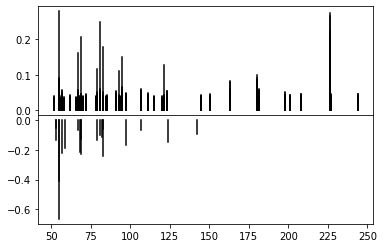

----
1844
nan
[('HMDB0014862', 0.1587464434339449, <mnet.Spectrum object at 0x11f89ec50>)]
('240.3036', 'C14H16N4', 'Imiquimod')


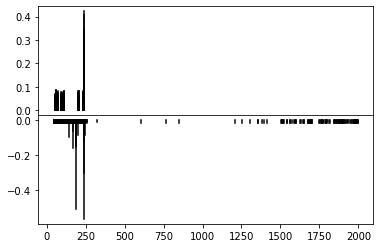

----
824
nan
[('HMDB0014375', 0.30931397971007646, <mnet.Spectrum object at 0x1211a6710>)]
('159.2261', 'C8H17NO2', 'Pregabalin')


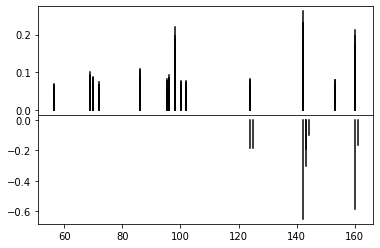

----
1016
nan
[('HMDB0000893', 0.171528929456043, <mnet.Spectrum object at 0x120c80c18>)]
('174.1944', 'C8H14O4', 'Suberic acid')


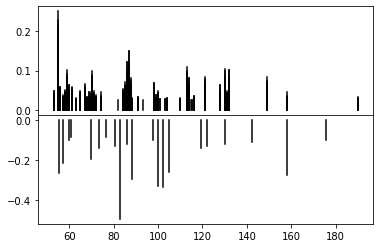

----
2038
nan
[('HMDB0015534', 0.11608836110578268, <mnet.Spectrum object at 0x11fb6a128>), ('HMDB0000273', 0.12086212434665371, <mnet.Spectrum object at 0x11e360a90>), ('HMDB0015534', 0.1116627138662883, <mnet.Spectrum object at 0x11e8a1240>)]
('281.2661', 'C15H11N3O3', 'Nitrazepam')
('242.2286', 'C10H14N2O5', 'Thymidine')
('281.2661', 'C15H11N3O3', 'Nitrazepam')


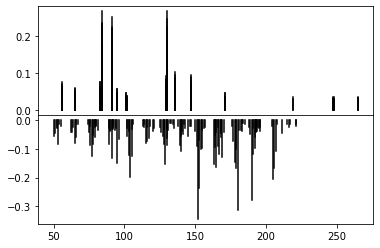

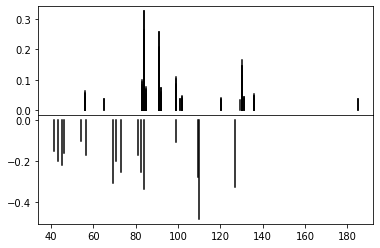

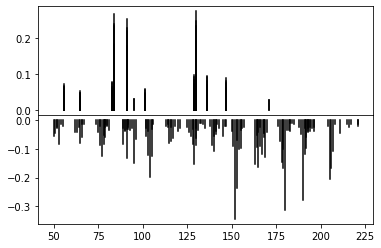

----
2293
nan
[('HMDB0015312', 0.16179969392052773, <mnet.Spectrum object at 0x11ff431d0>), ('HMDB0015312', 0.16179969392052773, <mnet.Spectrum object at 0x121dd2908>)]
('261.086', 'C7H15Cl2N2O2P', 'Ifosfamide')
('261.086', 'C7H15Cl2N2O2P', 'Ifosfamide')


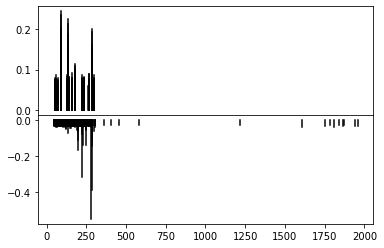

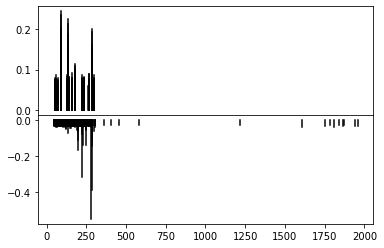

----
480
Hypoxanthine
[('HMDB0000157', 0.48549072398829063, <mnet.Spectrum object at 0x1211a6f98>)]
('136.1115', 'C5H4N4O', 'Hypoxanthine')


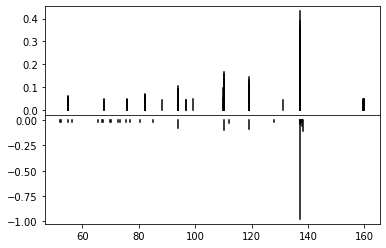

----
1068
nan
[('HMDB0000965', 0.1490707143815582, <mnet.Spectrum object at 0x11e867a58>), ('HMDB0001847', 0.19652400711688842, <mnet.Spectrum object at 0x1207ca3c8>)]
('109.147', 'C2H7NO2S', 'Hypotaurine')
('194.1906', 'C8H10N4O2', 'Caffeine')


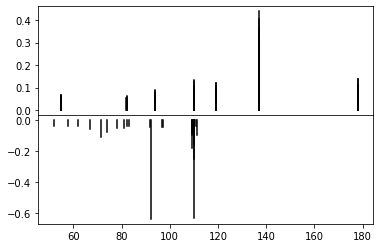

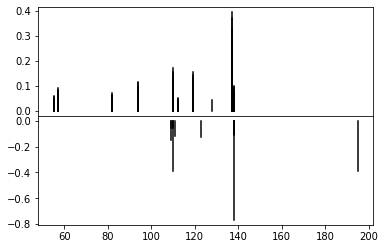

----
531
nan
[('HMDB0001906', 0.19145430485089812, <mnet.Spectrum object at 0x11fb6a860>)]
('103.1198', 'C4H9NO2', '2-Aminoisobutyric acid')


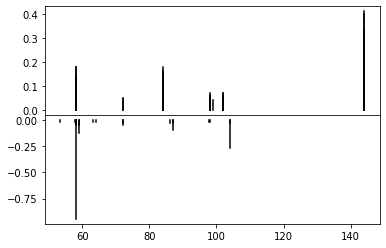

----
989
nan
[('HMDB0005015', 0.2619055381285538, <mnet.Spectrum object at 0x11ff43400>)]
('171.2368', 'C9H17NO2', 'Gabapentin')


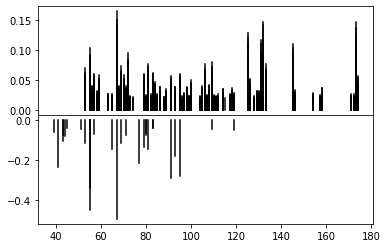

----
842
nan
[('HMDB0000062', 0.4706948575302457, <mnet.Spectrum object at 0x11e8f8470>)]
('161.1989', 'C7H15NO3', 'L-Carnitine')


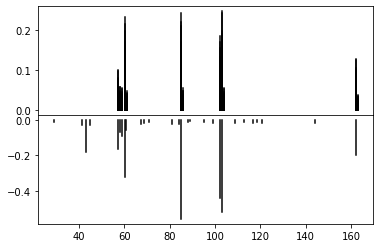

----
855
nan
[('HMDB0000062', 0.47296200959780416, <mnet.Spectrum object at 0x11fb6a588>), ('HMDB0001934', 0.35766767165540175, <mnet.Spectrum object at 0x1211a6d30>)]
('161.1989', 'C7H15NO3', 'L-Carnitine')
('162.2316', 'C10H14N2', 'Nicotine')


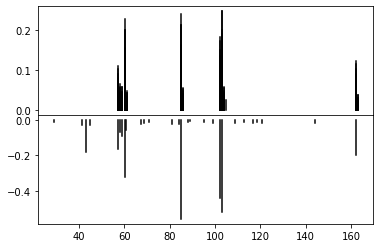

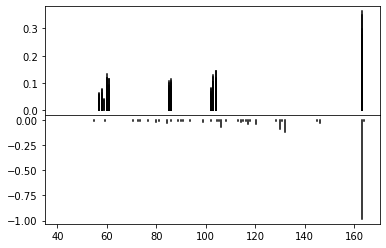

----
1970
nan
[('HMDB0015139', 0.11888683300337119, <mnet.Spectrum object at 0x11edbb320>), ('HMDB0015139', 0.1392288276333377, <mnet.Spectrum object at 0x121c312b0>)]
('255.2306', 'C9H13N5O4', 'Ganciclovir')
('255.2306', 'C9H13N5O4', 'Ganciclovir')


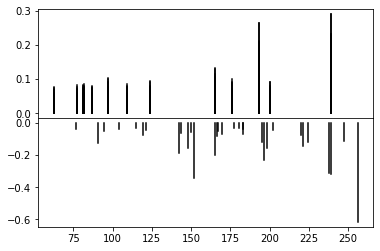

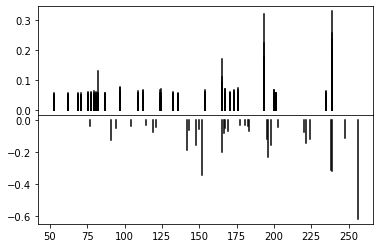

----
848
L-Carnitine
[('HMDB0000062', 0.4891108553190825, <mnet.Spectrum object at 0x11e8a1d68>), ('HMDB0000062', 0.4891108553190825, <mnet.Spectrum object at 0x11fe9e668>)]
('161.1989', 'C7H15NO3', 'L-Carnitine')
('161.1989', 'C7H15NO3', 'L-Carnitine')


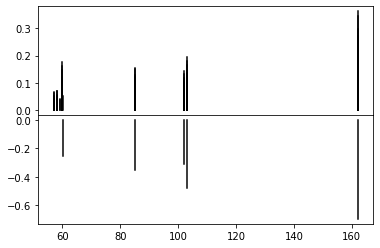

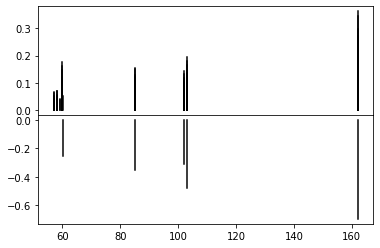

----
2235
nan
[('HMDB0014460', 0.195906554579848, <mnet.Spectrum object at 0x11e867da0>)]
('287.3568', 'C16H21N3O2', 'Zolmitriptan')


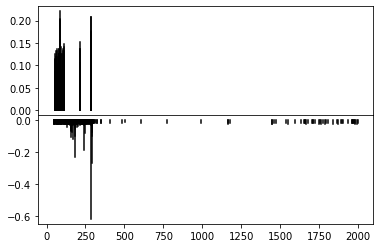

----
1295
nan
[('HMDB0001861', 0.16532552588056046, <mnet.Spectrum object at 0x11e867ef0>)]
('125.1716', 'C6H11N3', '3-Methylhistamine')


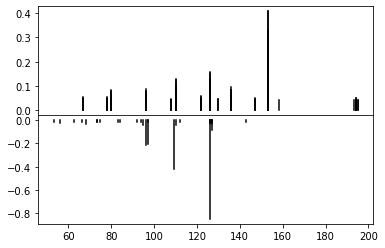

----
1821
nan
[('HMDB0015621', 0.24208934888610176, <mnet.Spectrum object at 0x11e867be0>)]
('310.329', 'C12H14N4O4S', 'Sulfadimethoxine')


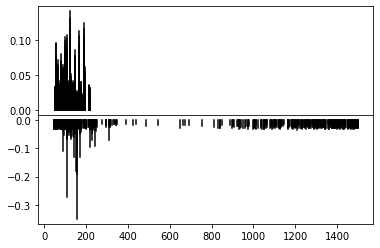

----
1572
nan
[('HMDB0000181', 0.32499289309599527, <mnet.Spectrum object at 0x1207ca198>)]
('197.1879', 'C9H11NO4', 'L-Dopa')


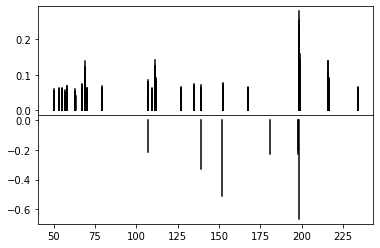

----
1499
nan
[('HMDB0015497', 0.18884111830646794, <mnet.Spectrum object at 0x1207caac8>)]
('228.2433', 'C14H12O3', 'Oxybenzone')


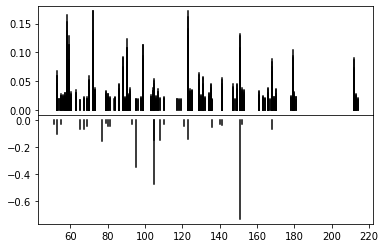

----
402
nan
[('HMDB0000070', 0.4288387599130686, <mnet.Spectrum object at 0x120c80ba8>)]
('129.157', 'C6H11NO2', 'Pipecolic acid')


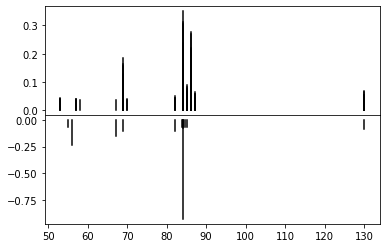

----
417
nan
[('HMDB0014375', 0.22015024497139657, <mnet.Spectrum object at 0x120fb97f0>), ('HMDB0001645', 0.4862813329998273, <mnet.Spectrum object at 0x11fb6acf8>), ('HMDB0001645', 0.25581883210408113, <mnet.Spectrum object at 0x1218706d8>)]
('159.2261', 'C8H17NO2', 'Pregabalin')
('131.1729', 'C6H13NO2', 'L-Norleucine')
('131.1729', 'C6H13NO2', 'L-Norleucine')


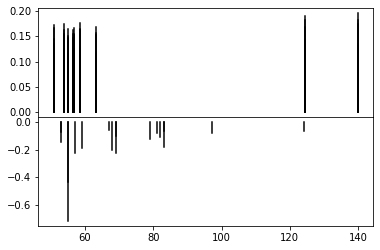

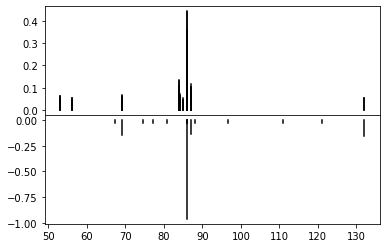

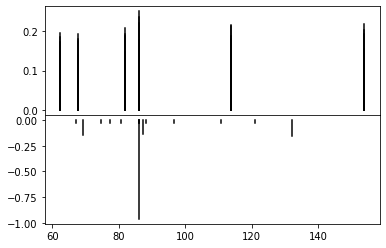

----
1010
nan
[('HMDB0000187', 0.28777954676521794, <mnet.Spectrum object at 0x1213a1400>)]
('105.0926', 'C3H7NO3', 'L-Serine')


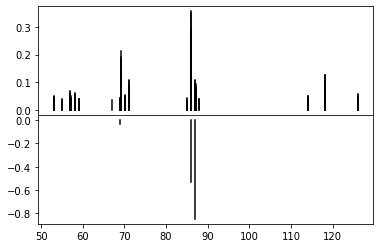

----
683
nan
[('HMDB0002040', 0.14084510899775493, <mnet.Spectrum object at 0x120fb9a20>), ('HMDB0002040', 0.14084510899775493, <mnet.Spectrum object at 0x1211a60b8>)]
('178.1846', 'C10H10O3', '4-Methoxycinnamic acid')
('178.1846', 'C10H10O3', '4-Methoxycinnamic acid')


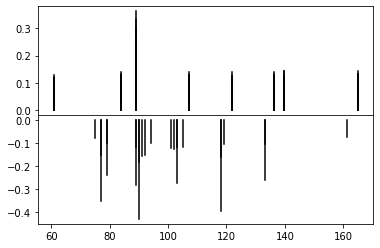

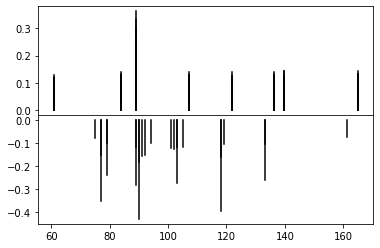

----
372
nan
[('HMDB0000070', 0.4512639423152608, <mnet.Spectrum object at 0x1207cae10>)]
('129.157', 'C6H11NO2', 'Pipecolic acid')


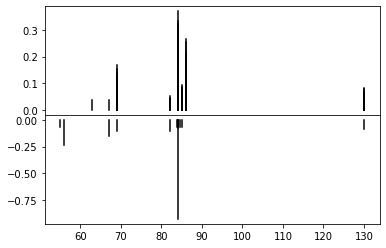

----
1105
L-Tyrosine
[('HMDB0000158', 0.4305522500501016, <mnet.Spectrum object at 0x11e867358>)]
('181.1885', 'C9H11NO3', 'L-Tyrosine')


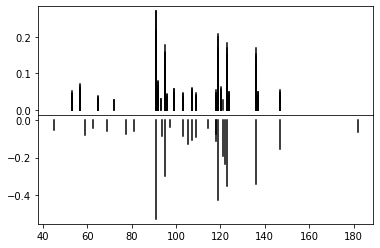

----
20
nan
[('HMDB0000925', 0.4746201748238167, <mnet.Spectrum object at 0x11e8a1898>)]
('75.1097', 'C3H9NO', 'Trimethylamine N-oxide')


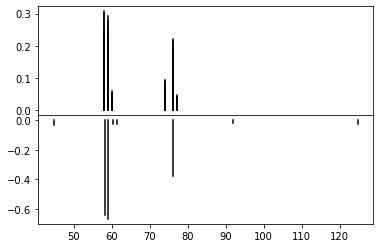

----
1544
nan
[('HMDB0014830', 0.07130201689156798, <mnet.Spectrum object at 0x11e8a16a0>), ('HMDB0015493', 0.19779402570709356, <mnet.Spectrum object at 0x11e8f83c8>), ('HMDB0015506', 0.2503368308963566, <mnet.Spectrum object at 0x11edbbd68>)]
('281.3523', 'C17H19N3O', 'Phentolamine')
('231.2936', 'C13H17N3O', 'Aminophenazone')
('213.2385', 'C11H11N5', 'Phenazopyridine')


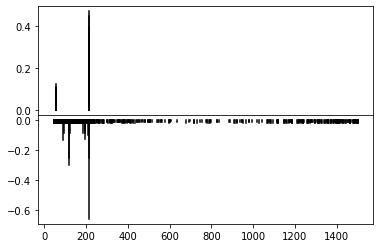

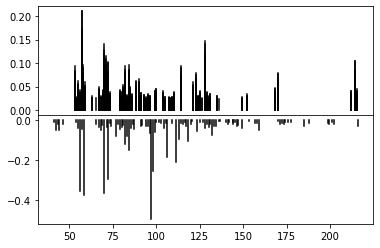

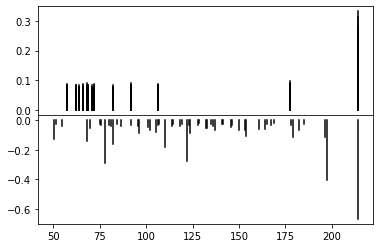

----
996
nan
[('HMDB0034315', 0.08510587016246086, <mnet.Spectrum object at 0x122aae240>), ('HMDB0014690', 0.1826187920838099, <mnet.Spectrum object at 0x11ee27470>), ('HMDB0034315', 0.08510587016246086, <mnet.Spectrum object at 0x11f89e160>)]
('208.2106', 'C11H12O4', '3-(3,4-Dimethoxyphenyl)-2-propenoic acid')
('170.232', 'C7H10N2OS', 'Propylthiouracil')
('208.2106', 'C11H12O4', '3-(3,4-Dimethoxyphenyl)-2-propenoic acid')


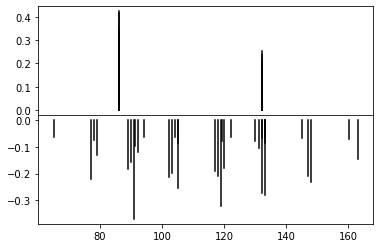

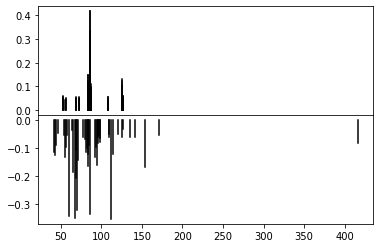

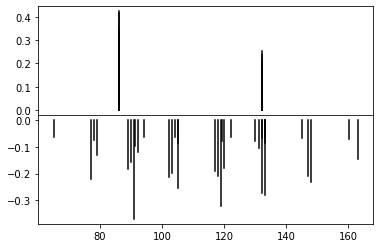

----
2384
nan
[('HMDB0014640', 0.15630611719584242, <mnet.Spectrum object at 0x11fe9e2b0>)]
('315.3636', 'C18H21NO4', 'Oxycodone')


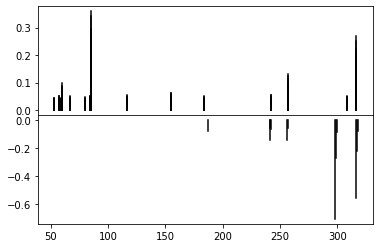

----
460
nan
[('HMDB0000073', 0.331121072817257, <mnet.Spectrum object at 0x1207ca828>)]
('153.1784', 'C8H11NO2', 'Dopamine')


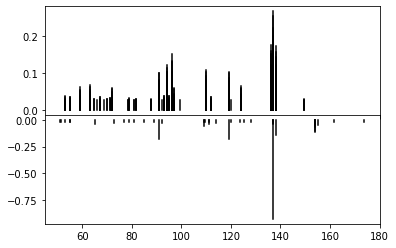

----
1712
nan
[('HMDB0015497', 0.2142801529058205, <mnet.Spectrum object at 0x1236d6240>), ('HMDB0034276', 0.20144141520010025, <mnet.Spectrum object at 0x11e867c18>)]
('228.2433', 'C14H12O3', 'Oxybenzone')
('210.2728', 'C11H18N2O2', 'L,L-Cyclo(leucylprolyl)')


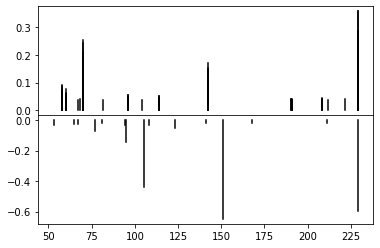

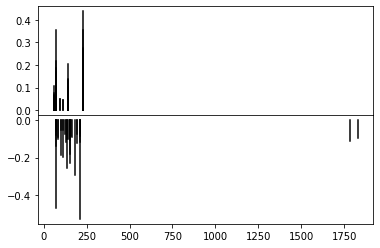

----
428
nan
[('HMDB0001901', 0.0653930240303684, <mnet.Spectrum object at 0x11fb6af98>)]
('131.1729', 'C6H13NO2', 'Aminocaproic acid')


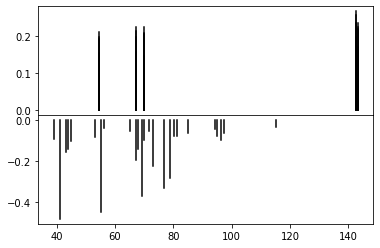

----
499
nan
[('HMDB0001895', 0.4620269526894077, <mnet.Spectrum object at 0x11ee279e8>)]
('138.122', 'C7H6O3', 'Salicylic acid')


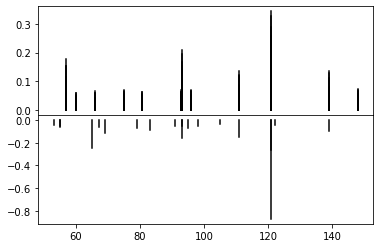

----
5793
nan
[('HMDB0015052', 0.17135316174300552, <mnet.Spectrum object at 0x121aa97b8>), ('HMDB0061006', 0.2806048506527923, <mnet.Spectrum object at 0x11e8a1ac8>), ('HMDB0015052', 0.17135316174300552, <mnet.Spectrum object at 0x11e867c88>)]
('171.154', 'C6H9N3O3', 'Metronidazole')
('232.3214', 'C14H20N2O', 'norfentanyl')
('171.154', 'C6H9N3O3', 'Metronidazole')


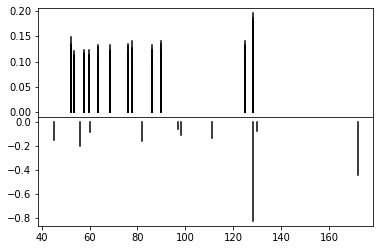

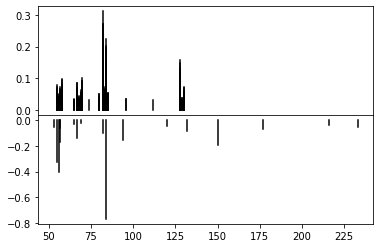

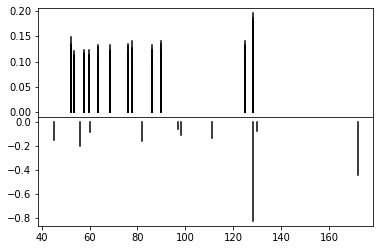

----
1669
nan
[('HMDB0014795', 0.31756343906922646, <mnet.Spectrum object at 0x122aae160>)]
('167.2911', 'C11H21N', 'Mecamylamine')


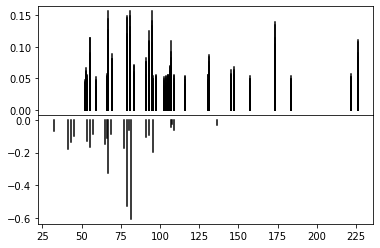

----
1623
Pantothenate
[('HMDB0000210', 0.3463334936533407, <mnet.Spectrum object at 0x11fb6a9b0>)]
('219.235', 'C9H17NO5', 'Pantothenic acid')


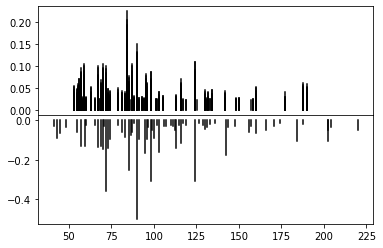

----
883
nan
[('HMDB0034315', 0.16509843905017849, <mnet.Spectrum object at 0x121870828>)]
('208.2106', 'C11H12O4', '3-(3,4-Dimethoxyphenyl)-2-propenoic acid')


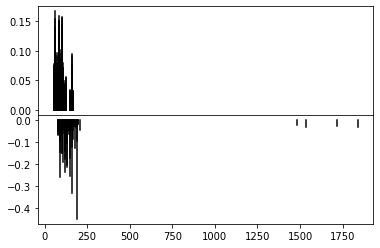

----
498
nan
[('HMDB0001895', 0.4620269526894077, <mnet.Spectrum object at 0x1213a1908>)]
('138.122', 'C7H6O3', 'Salicylic acid')


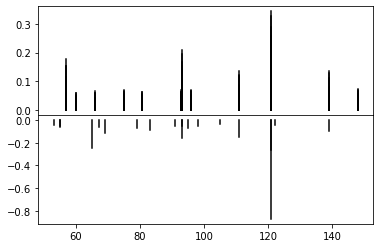

----
1839
L-Cystine
[('HMDB0015175', 0.06552303750784333, <mnet.Spectrum object at 0x11e8f8f98>), ('HMDB0015175', 0.06552303750784333, <mnet.Spectrum object at 0x122aae208>)]
('258.2295', 'C13H10N2O4', 'Thalidomide')
('258.2295', 'C13H10N2O4', 'Thalidomide')


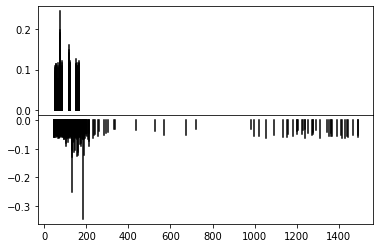

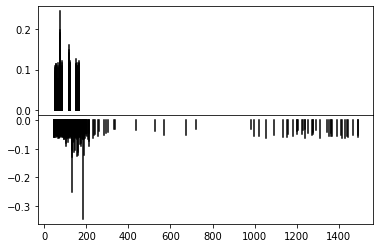

----
600
nan
[('HMDB0002243', 0.21139247456473537, <mnet.Spectrum object at 0x1236d69e8>)]
('123.1094', 'C6H5NO2', 'Picolinic acid')


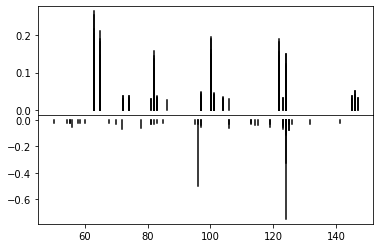

----
4109
nan
[('HMDB0005800', 0.34229269895344877, <mnet.Spectrum object at 0x1213a1550>), ('HMDB0005800', 0.34229269895344877, <mnet.Spectrum object at 0x1219940b8>)]
('286.2363', 'C15H10O6', 'Luteolin')
('286.2363', 'C15H10O6', 'Luteolin')


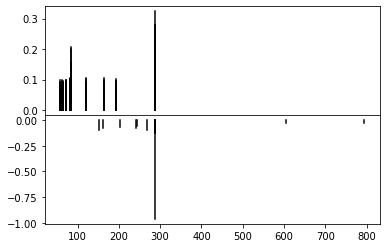

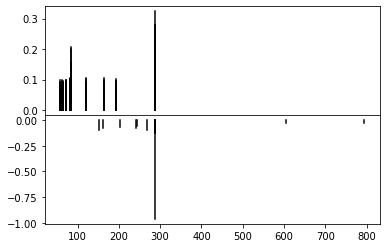

----
2019
nan
[('HMDB0015611', 0.19003930271835415, <mnet.Spectrum object at 0x121aa9eb8>), ('HMDB0015611', 0.19003930271835415, <mnet.Spectrum object at 0x1213a1358>)]
('203.2371', 'C12H13NO2', 'Methsuximide')
('203.2371', 'C12H13NO2', 'Methsuximide')


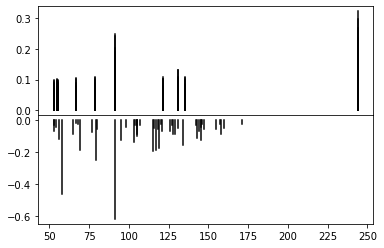

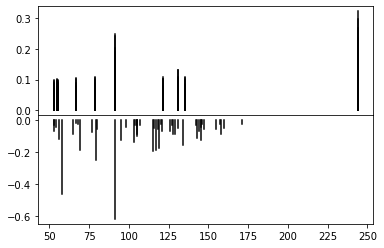

----
371
nan
[('HMDB0000070', 0.45041260904129243, <mnet.Spectrum object at 0x11e8a19e8>)]
('129.157', 'C6H11NO2', 'Pipecolic acid')


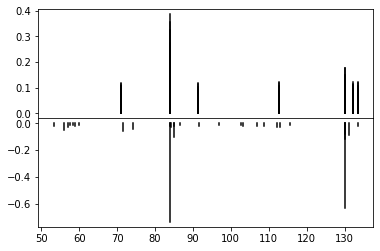

----
487
nan
[('HMDB0000157', 0.45321425738539034, <mnet.Spectrum object at 0x11fb6a7b8>)]
('136.1115', 'C5H4N4O', 'Hypoxanthine')


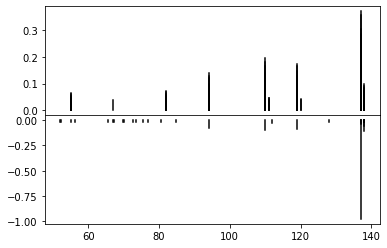

----
1684
nan
[('HMDB0014494', 0.2626044531000374, <mnet.Spectrum object at 0x1207cadd8>), ('HMDB0014494', 0.2626044531000374, <mnet.Spectrum object at 0x121c31dd8>)]
('209.2483', 'C9H15N5O', 'Minoxidil')
('209.2483', 'C9H15N5O', 'Minoxidil')


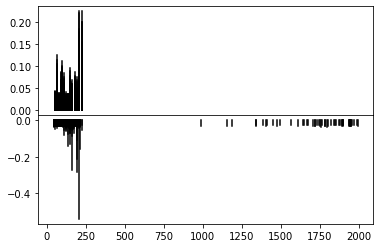

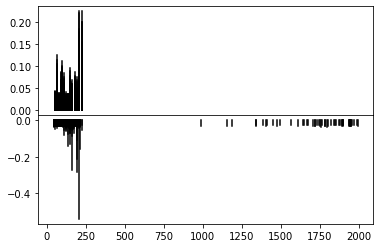

----
2416
nan
[('HMDB0014456', 0.0787587219206833, <mnet.Spectrum object at 0x121994b00>)]
('258.317', 'C9H10N2O3S2', 'Ethoxzolamide')


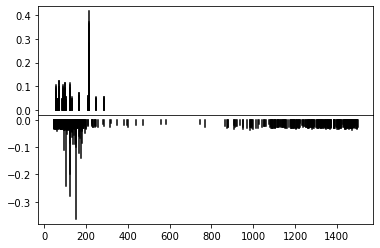

----
1442
nan
[('HMDB0015305', 0.33103946261179257, <mnet.Spectrum object at 0x120c800f0>)]
('232.2353', 'C12H12N2O3', 'Phenobarbital')


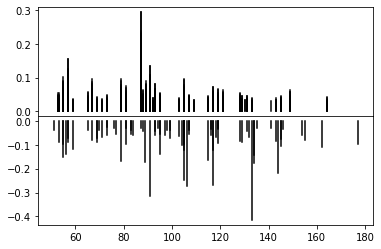

----
754
nan
[('HMDB0000177', 0.19703417097803383, <mnet.Spectrum object at 0x11edbb748>)]
('155.1546', 'C6H9N3O2', 'L-Histidine')


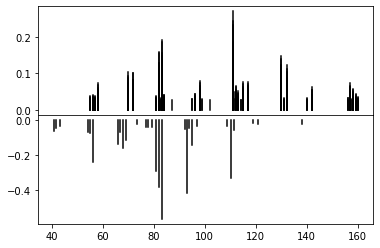

----
1740
nan
[('HMDB0014597', 0.2629463524945374, <mnet.Spectrum object at 0x11fb6a9e8>)]
('247.3327', 'C15H21NO2', 'Meperidine')


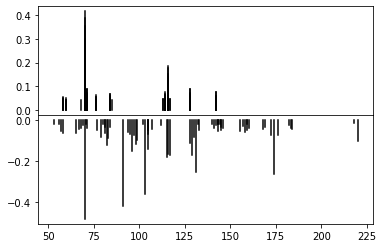

----
1895
nan
[('HMDB0000062', 0.31933523743125214, <mnet.Spectrum object at 0x11e867208>)]
('161.1989', 'C7H15NO3', 'L-Carnitine')


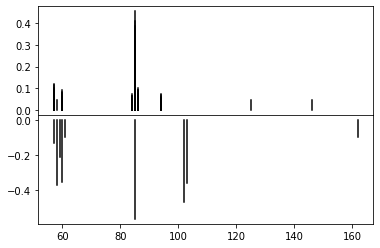

----
344
nan
[('HMDB0002434', 0.10672301141651033, <mnet.Spectrum object at 0x120c809b0>), ('HMDB0000641', 0.13428837330696664, <mnet.Spectrum object at 0x120fb9eb8>)]
('110.1106', 'C6H6O2', 'Hydroquinone')
('146.1445', 'C5H10N2O3', 'L-Glutamine')


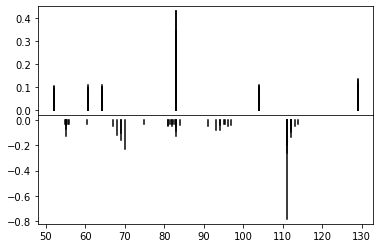

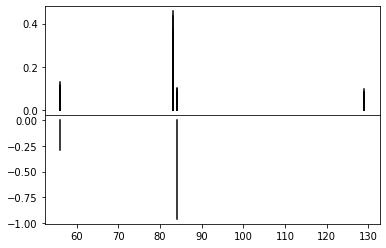

----
1363
nan
[('HMDB0000162', 0.07975385431207188, <mnet.Spectrum object at 0x11ff43e80>), ('HMDB0001901', 0.2927305029994872, <mnet.Spectrum object at 0x1207ca358>)]
('115.1305', 'C5H9NO2', 'L-Proline')
('131.1729', 'C6H13NO2', 'Aminocaproic acid')


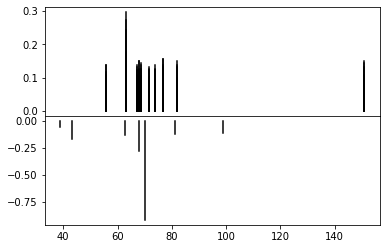

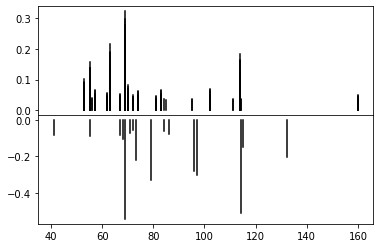

----
2093
nan
[('HMDB0003217', 0.20329633131709357, <mnet.Spectrum object at 0x11e8f87b8>)]
('270.24', 'C15H10O5', 'Genistein')


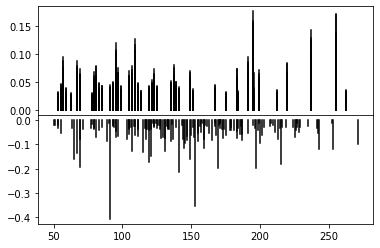

----
444
nan
[('HMDB0000191', 0.20020006481630764, <mnet.Spectrum object at 0x1216b10f0>)]
('133.1027', 'C4H7NO4', 'L-Aspartic acid')


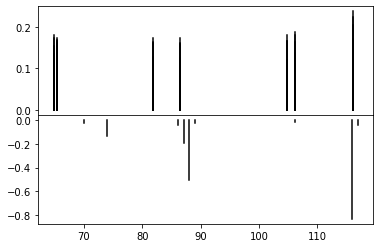

----
3438
nan
[('HMDB0005809', 0.22507658259986071, <mnet.Spectrum object at 0x11e8670b8>)]
('164.2011', 'C10H12O2', 'Eugenol')


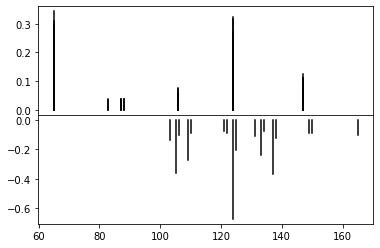

----
953
nan
[('HMDB0000479', 0.2696433808214774, <mnet.Spectrum object at 0x1207cad68>)]
('169.1811', 'C7H11N3O2', '3-Methylhistidine')


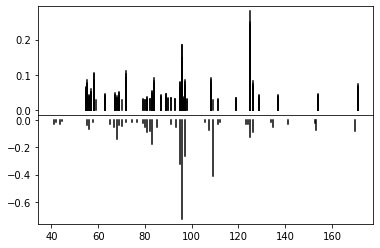

----
254
nan
[('HMDB0000043', 0.4691045488557135, <mnet.Spectrum object at 0x1219949b0>), ('HMDB0000883', 0.42244326522264924, <mnet.Spectrum object at 0x1225e8be0>)]
('117.1463', 'C5H11NO2', 'Betaine')
('117.1463', 'C5H11NO2', 'L-Valine')


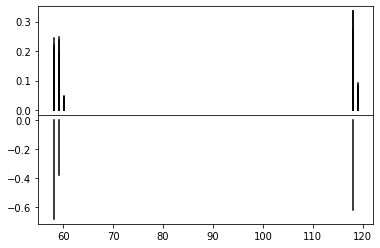

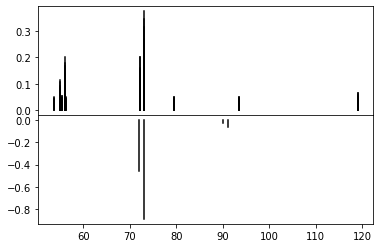

----
258
nan
[('HMDB0000167', 0.45599536394874823, <mnet.Spectrum object at 0x120c804a8>)]
('119.1192', 'C4H9NO3', 'L-Threonine')


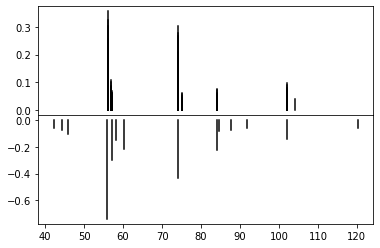

----
541
nan
[('HMDB0000097', 0.05977208085558724, <mnet.Spectrum object at 0x11e0f1d68>)]
('104.1708', 'C5H14NO', 'Choline')


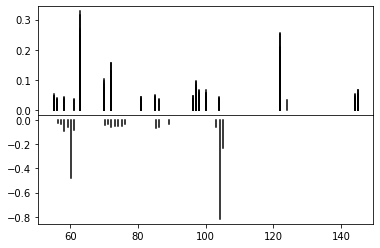

----
187
nan
[('HMDB0000562', 0.5465124997376563, <mnet.Spectrum object at 0x121aa9f28>), ('HMDB0000562', 0.5650537161209404, <mnet.Spectrum object at 0x1216b1d68>)]
('113.1179', 'C4H7N3O', 'Creatinine')
('113.1179', 'C4H7N3O', 'Creatinine')


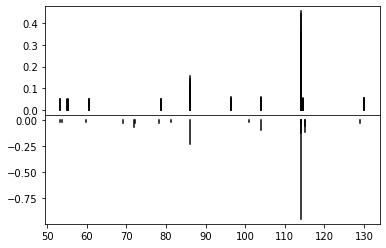

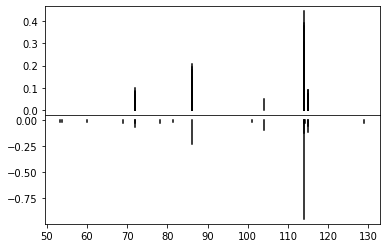

----
2412
nan
[('HMDB0014750', 0.20814300224199744, <mnet.Spectrum object at 0x122aae048>)]
('325.443', 'C18H31NO4', 'Bisoprolol')


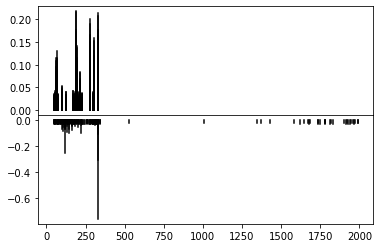

----
635
nan
[('HMDB0000017', 0.2380845291919352, <mnet.Spectrum object at 0x121c316a0>)]
('183.1614', 'C8H9NO4', '4-Pyridoxic acid')


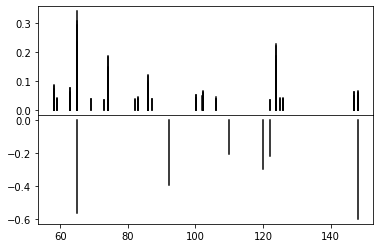

----
1
nan
[('HMDB0000162', 0.4179300561263688, <mnet.Spectrum object at 0x1213a14a8>)]
('115.1305', 'C5H9NO2', 'L-Proline')


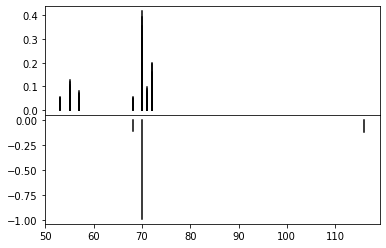

----
418
nan
[('HMDB0000022', 0.18913209876669912, <mnet.Spectrum object at 0x11fb6ad68>), ('HMDB0001149', 0.2824664537127042, <mnet.Spectrum object at 0x11e8f8be0>)]
('167.205', 'C9H13NO2', '3-Methoxytyramine')
('131.1299', 'C5H9NO3', '5-Aminolevulinic acid')


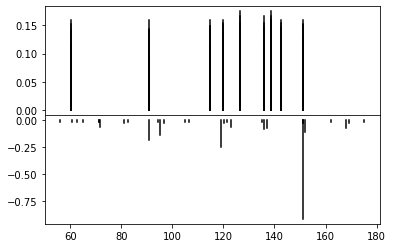

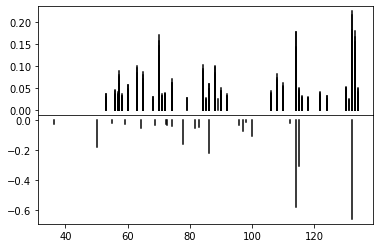

----
670
nan
[('HMDB0011600', 0.35448556223447586, <mnet.Spectrum object at 0x122aaec88>)]
('149.1533', 'C6H7N5', '3-Methyladenine')


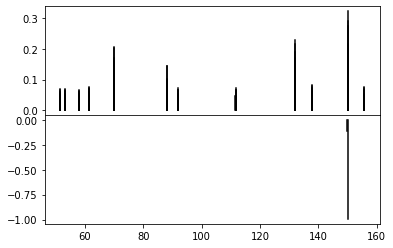

----
239
nan
[('HMDB0000883', 0.4606088800979791, <mnet.Spectrum object at 0x1218709e8>), ('HMDB0000883', 0.44295621211417113, <mnet.Spectrum object at 0x121c317f0>)]
('117.1463', 'C5H11NO2', 'L-Valine')
('117.1463', 'C5H11NO2', 'L-Valine')


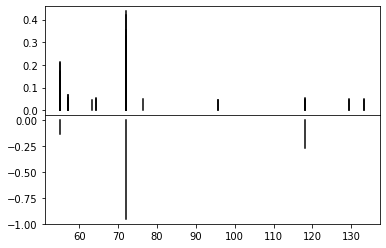

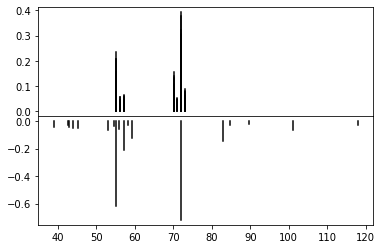

----
183
Creatinine
[('HMDB0000562', 0.5419185899236829, <mnet.Spectrum object at 0x1213a1cf8>), ('HMDB0000562', 0.5555199927568796, <mnet.Spectrum object at 0x1213a10f0>), ('HMDB0000562', 0.5419185899236829, <mnet.Spectrum object at 0x1213a1c18>)]
('113.1179', 'C4H7N3O', 'Creatinine')
('113.1179', 'C4H7N3O', 'Creatinine')
('113.1179', 'C4H7N3O', 'Creatinine')


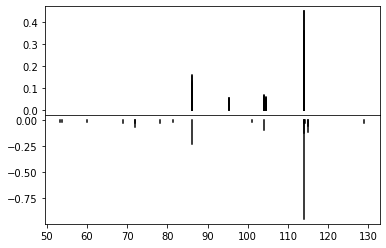

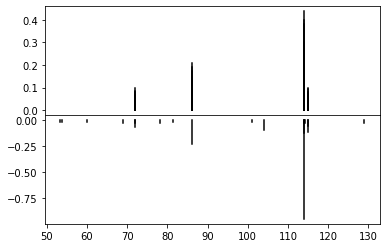

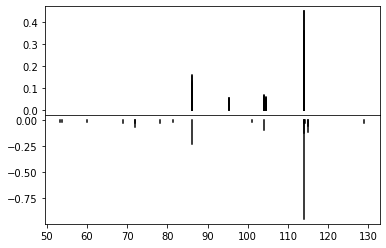

----
240
Betaine
[('HMDB0000043', 0.4760119621588095, <mnet.Spectrum object at 0x11ff43eb8>), ('HMDB0000043', 0.6635662941527527, <mnet.Spectrum object at 0x11e867588>)]
('117.1463', 'C5H11NO2', 'Betaine')
('117.1463', 'C5H11NO2', 'Betaine')


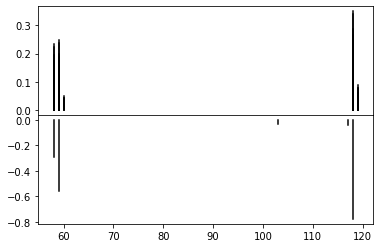

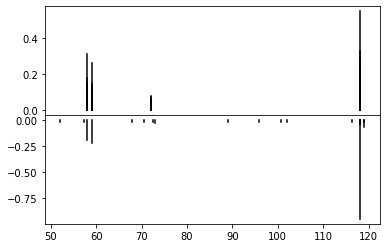

----
412
nan
[('HMDB0000725', 0.34661622543099985, <mnet.Spectrum object at 0x11e8f84a8>), ('HMDB0000965', 0.3048121408219141, <mnet.Spectrum object at 0x11fe9e7f0>)]
('131.1299', 'C5H9NO3', '4-Hydroxyproline')
('109.147', 'C2H7NO2S', 'Hypotaurine')


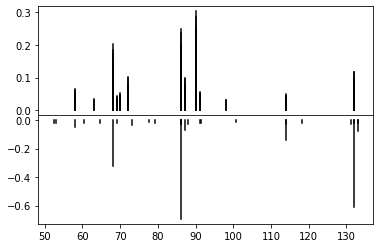

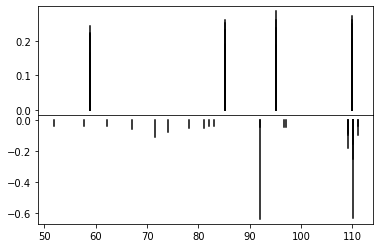

----
1337
nan
[('HMDB0014375', 0.38694466461561283, <mnet.Spectrum object at 0x11e8f8128>)]
('159.2261', 'C8H17NO2', 'Pregabalin')


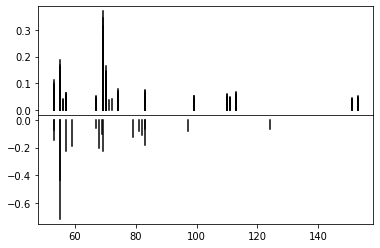

----
497
nan
[('HMDB0001866', 0.23686385318981404, <mnet.Spectrum object at 0x1236d6f28>)]
('184.1461', 'C8H8O5', '3,4-Dihydroxymandelic acid')


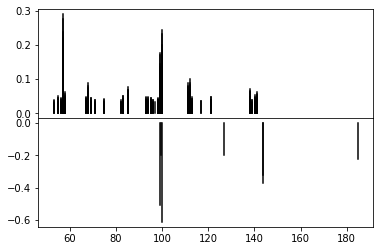

----
4923
nan
[('HMDB0000068', 0.2144747472595841, <mnet.Spectrum object at 0x11ff43b38>)]
('183.2044', 'C9H13NO3', 'Epinephrine')


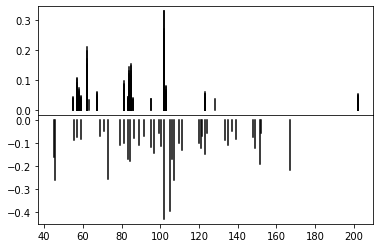

----
922
nan
[('HMDB0014748', 0.400432862716507, <mnet.Spectrum object at 0x11ff43c18>)]
('167.205', 'C9H13NO2', 'Metaraminol')


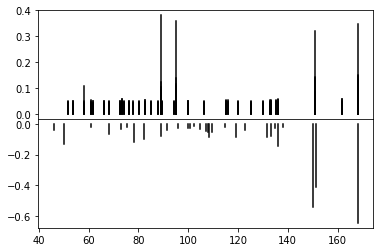

----
760
nan
[('HMDB0000517', 0.378810614682599, <mnet.Spectrum object at 0x11ff43898>)]
('174.201', 'C6H14N4O2', 'L-Arginine')


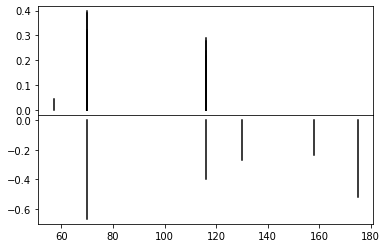

----
49
nan
[('HMDB0001645', 0.4427878220797046, <mnet.Spectrum object at 0x121aa96a0>), ('HMDB0000172', 0.19694417737559702, <mnet.Spectrum object at 0x11fb6a668>)]
('131.1729', 'C6H13NO2', 'L-Norleucine')
('131.1729', 'C6H13NO2', 'L-Isoleucine')


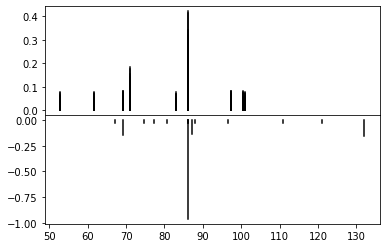

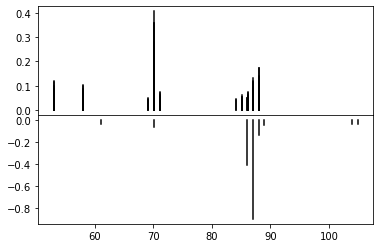

----
223
nan
[('HMDB0000162', 0.4804180919590106, <mnet.Spectrum object at 0x11e867630>)]
('115.1305', 'C5H9NO2', 'L-Proline')


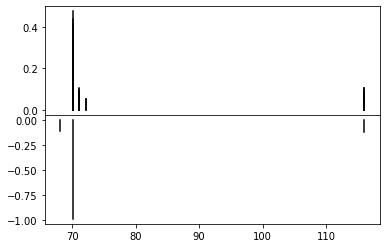

----
2351
nan
[('HMDB0014615', 0.2087410933606196, <mnet.Spectrum object at 0x1219942e8>), ('HMDB0014615', 0.2087410933606196, <mnet.Spectrum object at 0x11ff43a90>)]
('309.3261', 'C17H18F3NO', 'Fluoxetine')
('309.3261', 'C17H18F3NO', 'Fluoxetine')


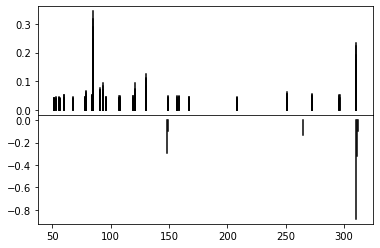

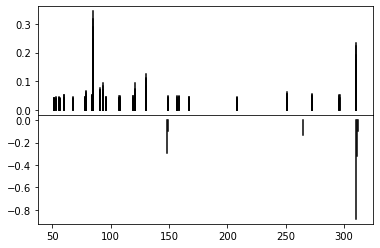

----
2870
nan
[(0, 0, 0)]
----
111
nan
[('HMDB0000719', 0.0868432144953065, <mnet.Spectrum object at 0x11f89ecc0>)]
('119.1192', 'C4H9NO3', 'L-Homoserine')


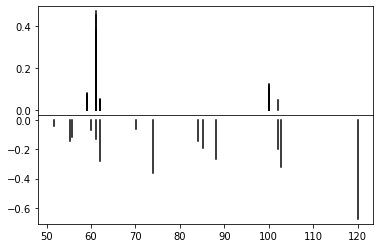

----
2012
nan
[('HMDB0015008', 0.18067164787187837, <mnet.Spectrum object at 0x121994fd0>)]
('260.308', 'C14H12O3S', 'Suprofen')


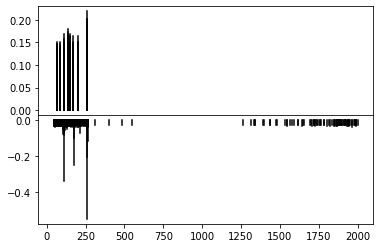

----
2478
nan
[('HMDB0015141', 0.0828529646774594, <mnet.Spectrum object at 0x11fe9e9b0>), ('HMDB0015141', 0.0828529646774594, <mnet.Spectrum object at 0x1236d6780>)]
('285.3027', 'C17H11N5', 'Letrozole')
('285.3027', 'C17H11N5', 'Letrozole')


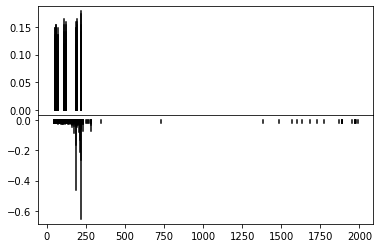

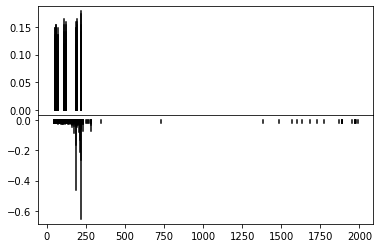

----
2441
nan
[('HMDB0014694', 0.24626709180759482, <mnet.Spectrum object at 0x11e8679b0>)]
('331.346', 'C15H13N3O4S', 'Piroxicam')


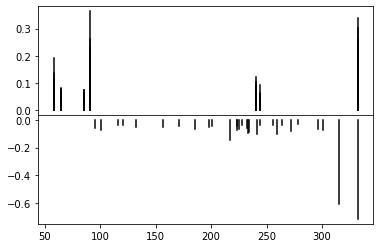

----
181
nan
[('HMDB0000272', 0.2614610622261586, <mnet.Spectrum object at 0x11ff430b8>)]
('185.0725', 'C3H8NO6P', 'Phosphoserine')


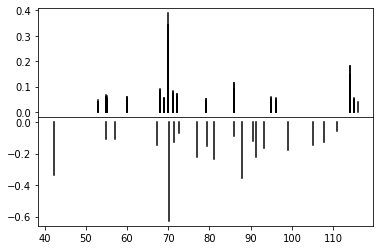

----
6
nan
[('HMDB0000883', 0.47757587619062447, <mnet.Spectrum object at 0x11e8f8ba8>), ('HMDB0000883', 0.4255511302183394, <mnet.Spectrum object at 0x11e8f86d8>)]
('117.1463', 'C5H11NO2', 'L-Valine')
('117.1463', 'C5H11NO2', 'L-Valine')


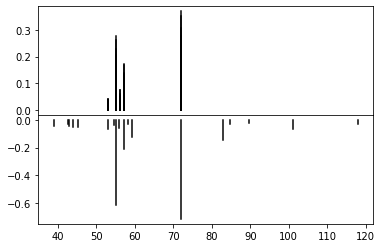

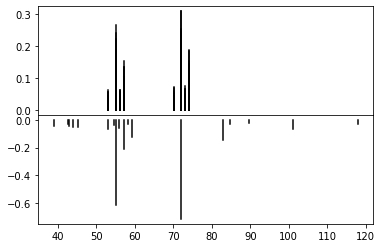

----
416
nan
[('HMDB0000064', 0.28953291527298636, <mnet.Spectrum object at 0x121242da0>), ('HMDB0000064', 0.28953291527298636, <mnet.Spectrum object at 0x11e867668>)]
('131.1332', 'C4H9N3O2', 'Creatine')
('131.1332', 'C4H9N3O2', 'Creatine')


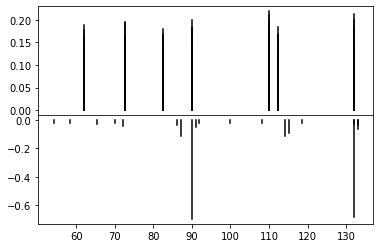

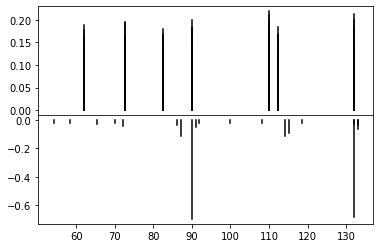

----
1154
nan
[('HMDB0014795', 0.12317142866884441, <mnet.Spectrum object at 0x121870ac8>)]
('167.2911', 'C11H21N', 'Mecamylamine')


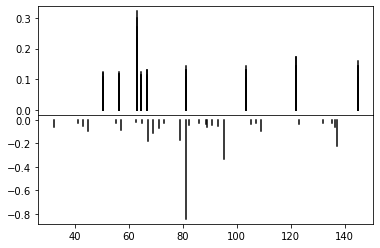

----
233
nan
[('HMDB0000128', 0.3934160314311954, <mnet.Spectrum object at 0x120fb9438>)]
('117.1066', 'C3H7N3O2', 'Guanidoacetic acid')


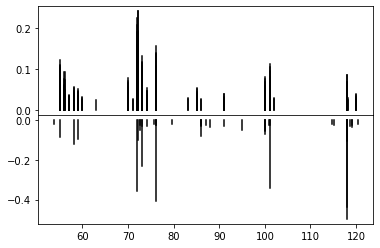

----
352
nan
[('HMDB0003357', 0.21977819200698992, <mnet.Spectrum object at 0x121994ba8>)]
('174.1977', 'C7H14N2O3', 'N-Acetylornithine')


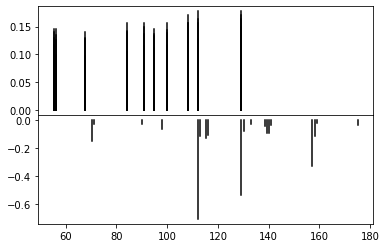

----
777
nan
[('HMDB0000517', 0.25613996616596296, <mnet.Spectrum object at 0x1212429e8>)]
('174.201', 'C6H14N4O2', 'L-Arginine')


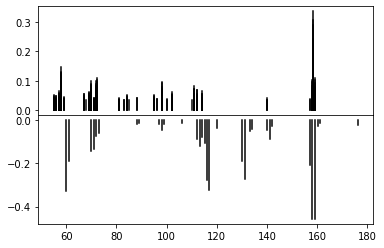

----
1822
nan
[('HMDB0001964', 0.1534860731591503, <mnet.Spectrum object at 0x11f89e2b0>), ('HMDB0015621', 0.2661001825677231, <mnet.Spectrum object at 0x120c803c8>)]
('180.1574', 'C9H8O4', 'Caffeic acid')
('310.329', 'C12H14N4O4S', 'Sulfadimethoxine')


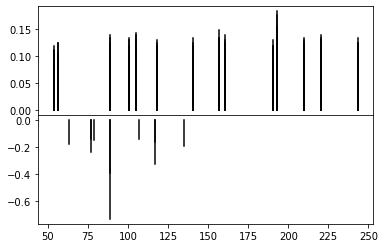

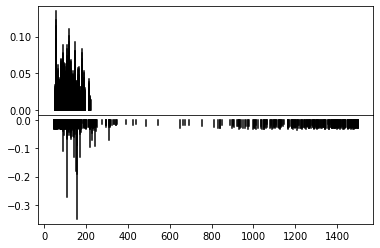

----
636
nan
[('HMDB0000017', 0.2308221620676222, <mnet.Spectrum object at 0x121870e48>)]
('183.1614', 'C8H9NO4', '4-Pyridoxic acid')


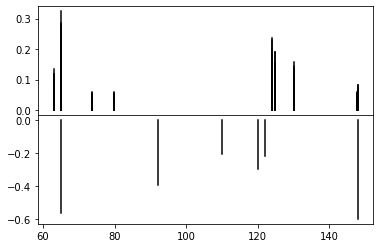

----
805
nan
[('HMDB0000197', 0.17020043888508127, <mnet.Spectrum object at 0x121c314a8>), ('HMDB0000904', 0.14318418086325602, <mnet.Spectrum object at 0x11e8a1a90>)]
('175.184', 'C10H9NO2', 'Indoleacetic acid')
('175.1857', 'C6H13N3O3', 'Citrulline')


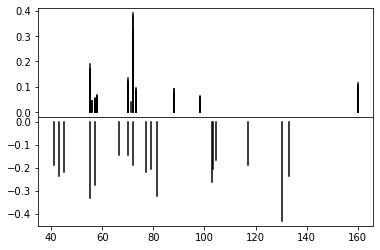

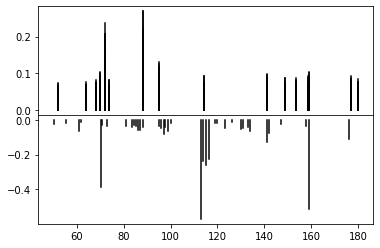

----
10779
N(pi)-Methyl-L-histidine
[('HMDB0000479', 0.45270710926075575, <mnet.Spectrum object at 0x1207caa90>), ('HMDB0000479', 0.404953831441955, <mnet.Spectrum object at 0x11fe9e940>)]
('169.1811', 'C7H11N3O2', '3-Methylhistidine')
('169.1811', 'C7H11N3O2', '3-Methylhistidine')


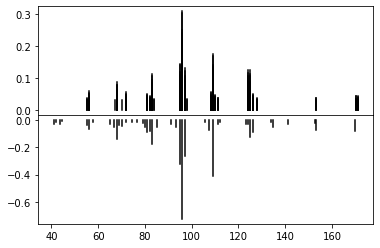

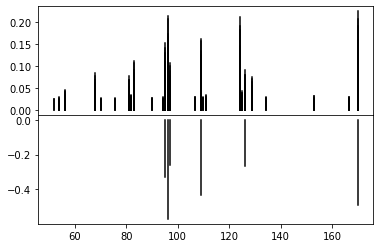

----


In [49]:
%matplotlib inline
for i, row in annotated_data_with_spectra.iterrows():
    print(row['custom_id'])
    print(row['standards_match'])
    print(row['matchesHMDB'])

    spectra = row['spectra']
   
    normalised_peaks_top_list = []
    normalised_peaks_bottom_list = []
    for spectrum in spectra:

       
        normalised_peaks_top = spectra[spectrum].normalised_peaks
        normalised_peaks_top_list.append(normalised_peaks_top)
    for f in row['matchesHMDB']:
        if f[0] in metabolites:
            print(metabolites[f[0]])
        if f[2] != 0:
            normalised_peaks_bottom = f[2].normalised_peaks
            normalised_peaks_bottom_list.append(normalised_peaks_bottom)
        
    

        
    for top, bottom in zip(normalised_peaks_top_list, normalised_peaks_bottom_list):
        if bottom != 0:
            plot_mirror(top, bottom)

        
        
    print('----')